# Subclustering of head ectoderm in Integration data

In [1]:
#loading packages
library(Seurat)
library(ggplot2)
library(magrittr)
library(data.table)
library(Matrix)
library(dplyr)
library(tibble)
library(harmony) #for integration


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp



In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] harmony_0.1.0     Rcpp_1.0.7        tibble_3.0.5      dplyr_1.0.3      
[5] Matrix_1.3-2      data.table_1.13.6 magrittr_2.0.1    ggplot2_3.3.3    
[9] Seurat_3.2.3     

loaded via a namespace (and not attached):
 [1] nlme_3.1-151          matrixStats_0.57.0    RcppAnnoy_0.0.18     
 [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
 [7] sctransform_0.3.2     tools_4.0.3           R6_2.5.1             
[10] irlba_2.3.3           rpart_4.1-15          KernSmooth_2.23-18

In [3]:
func.centering <- function(seu){
    DefaultAssay(seu) <- 'SCT'
    scale.data <- GetAssayData(seu, assay = 'SCT', slot = 'scale.data') #Get scale.data
    new.data <- ScaleData(object = scale.data, do.scale = F, do.center = T) #centering scale.data
    
    seu <- SetAssayData(object = seu, assay = 'SCT',
                        slot = 'scale.data', new.data = new.data) #insert centering data into scale.data slot
    return(seu)
    
}

func.normalize <- function(seu){
    
    if(dim(seu)[2]>=500){
        #Re-Normalize data only when the number of cell in the target clusters > 500.
        DefaultAssay(seu) <- 'RNA'
        if(seu$set[1]=='Set 1'){
            vars.to.regress <- c("percent.mt", "percent.rRNA","percent.ERCC")
        }else{
            vars.to.regress <- c("percent.mt", "percent.rRNA")
        }
        seu <- suppressWarnings(SCTransform(seu, vars.to.regress = vars.to.regress))
    }else{
        #If The number of cells < 500, re-normalization is skipped and only centering is performed.
        seu <- func.centering(seu)
    }
    return(seu)
}

func.subclustering.prep <- function(seu){
    obj.list <- SplitObject(seu, split.by = 'set')
    
    print(obj.list)
    
    obj.list <- lapply(X = obj.list, FUN = func.normalize)
    print(obj.list)
    integration.features <- SelectIntegrationFeatures(object.list = obj.list, nfeatures = 3000)
    seu <- merge(x = obj.list[['Set 3']], y = c(obj.list[['Set 2']],obj.list[['Set 1']],obj.list[['NK-data']]))
    VariableFeatures(seu) <- integration.features
    seu <- RunPCA(seu)
    seu <- RunHarmony(object = seu, group.by.vars = 'set', assay.use="SCT")
    seu <- RunUMAP(seu, dims = 1:30, n.neighbors = 20L, reduction = 'harmony')
    seu <- RunUMAP(seu, dims = 1:30, n.neighbors = 20L, reduction = 'pca', reduction.name = 'umapwoharmony')

    options(repr.plot.width=16, repr.plot.height=8)
    p <- DimPlot(seu, reduction = 'umapwoharmony', group.by = 'set') + DimPlot(seu, reduction = 'umap', group.by = 'set')
    plot(p)
    
    print(seu)
    return(seu)
}

func.subclustering <- function(seu, resolution=0.8){
    seu <- FindNeighbors(seu, dims = 1:30, reduction = 'harmony')
    seu <- FindClusters(seu, resolution = resolution)
    options(repr.plot.width=16, repr.plot.height=8)
    p <- DimPlot(seu, reduction = 'umap', label = T) + NoLegend() + DimPlot(seu, reduction = 'umap', group.by = 'set')
    plot(p)
    return(seu)
}

In [4]:
#loading data
seu_HQC <- readRDS(file = '../../data/seurat_object/all_integration/seu_Harmony_integrated.obj')
seu_HQC

An object of class Seurat 
25136 features across 13467 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


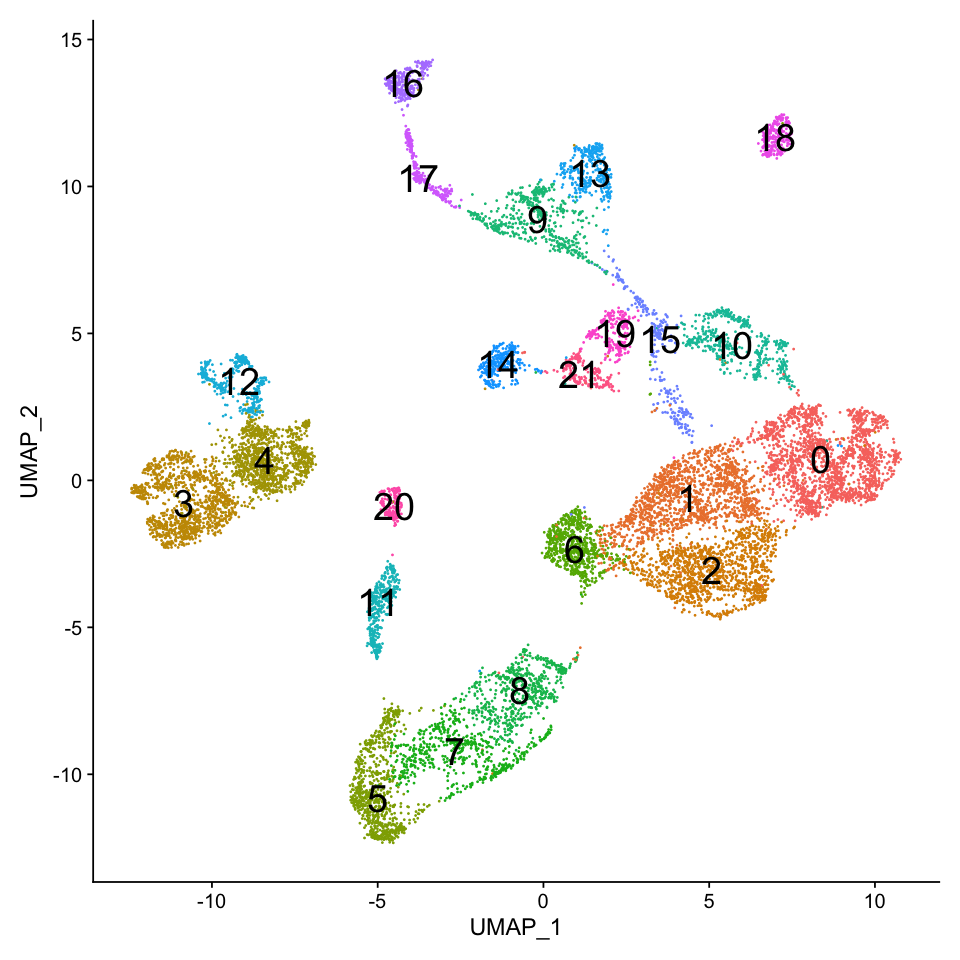

In [5]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_HQC, reduction = 'umap', label = TRUE, label.size = 8) + NoLegend()

## Picking up target clusters

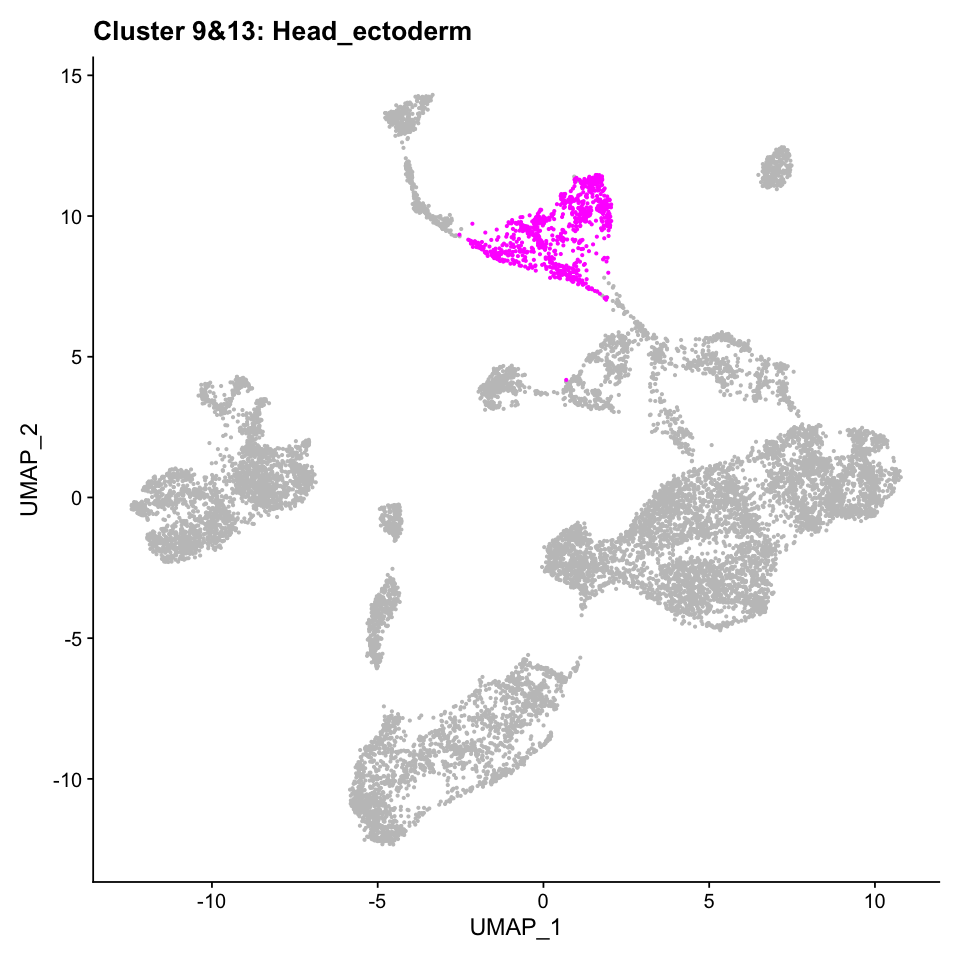

In [6]:
options(repr.plot.width=8, repr.plot.height=8)
highlight.cells <- WhichCells(seu_HQC,idents = c(9,13))
DimPlot(seu_HQC, reduction =  "umap", cells.highlight = highlight.cells, pt.size = 0.5, sizes.highlight = 0.5,
        cols.highlight = 'magenta', label = FALSE) + NoLegend() + ggtitle('Cluster 9&13: Head_ectoderm')

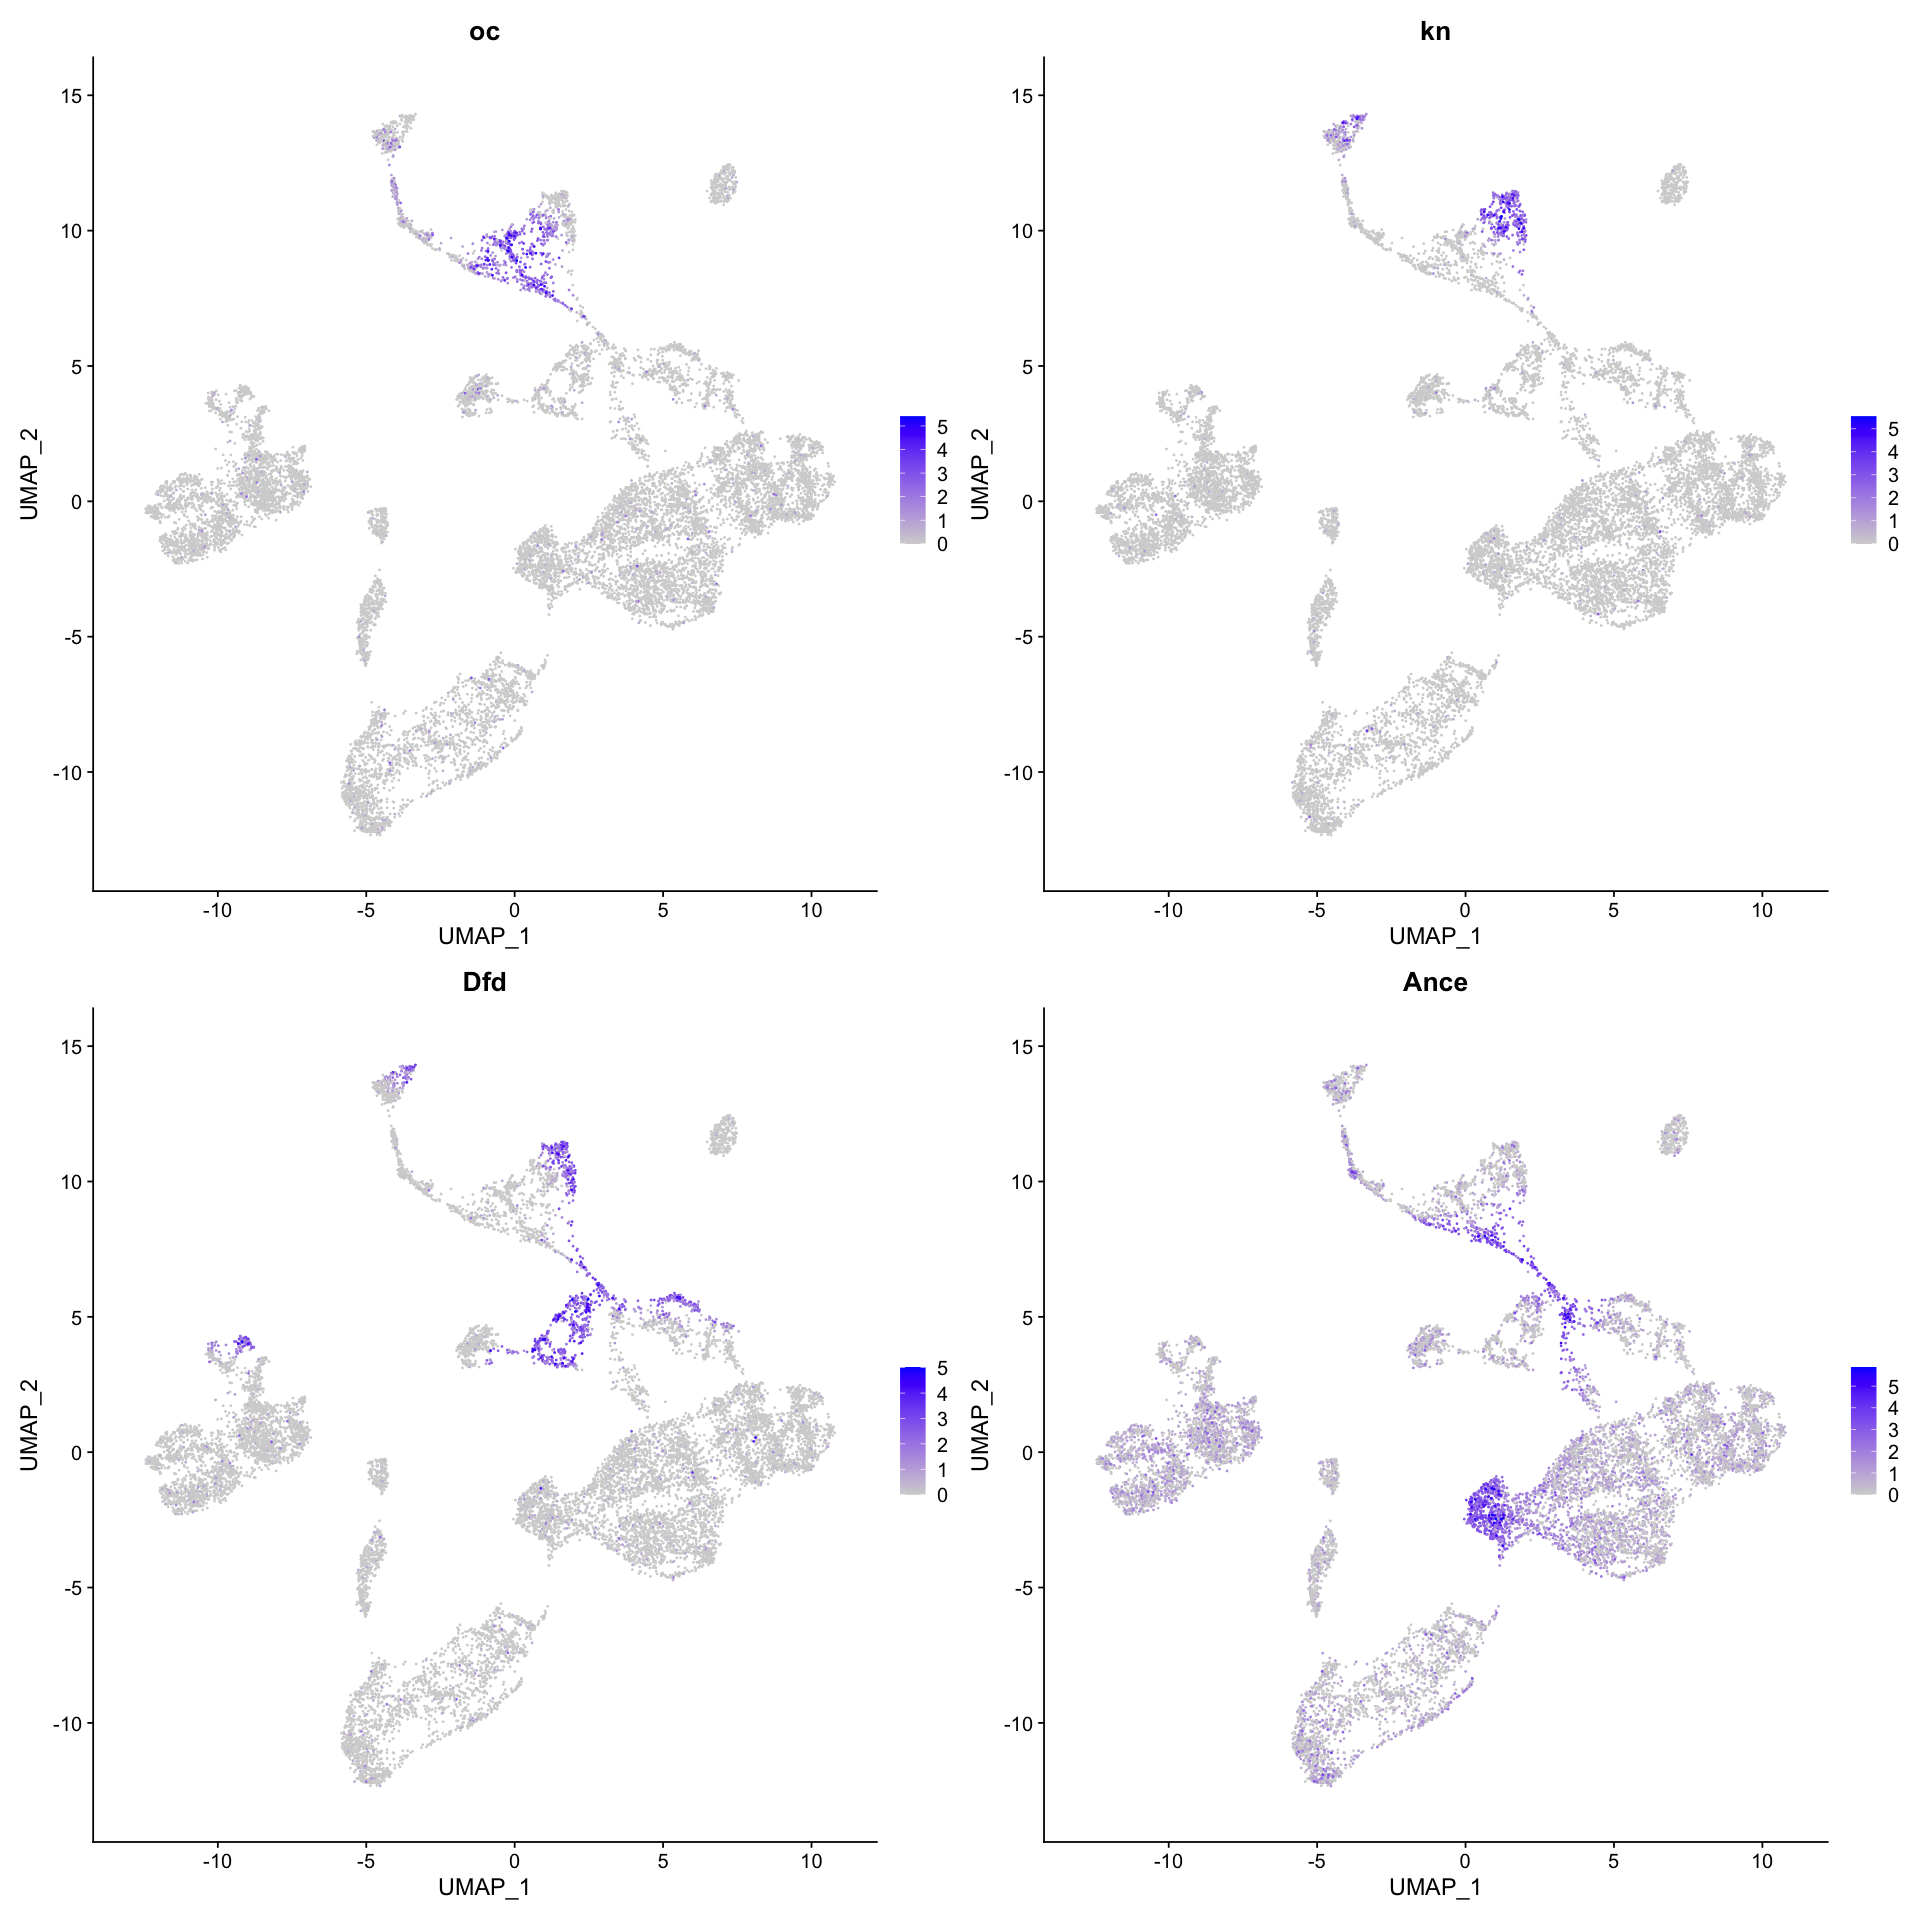

In [7]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, features = c('oc','kn','Dfd','Ance'))

In [8]:
seu.head <- subset(seu_HQC, idents = c(9,13))
seu.head$cluster.allcell <- seu.head$seurat_clusters
seu.head

An object of class Seurat 
25136 features across 819 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

## Clustering

$`Set 3`
An object of class Seurat 
25136 features across 329 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 2`
An object of class Seurat 
25136 features across 246 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`NK-data`
An object of class Seurat 
25136 features across 152 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 1`
An object of class Seurat 
25136 features across 92 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony



Centering data matrix

Centering data matrix

Centering data matrix

Centering data matrix



$`Set 3`
An object of class Seurat 
25136 features across 329 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 2`
An object of class Seurat 
25136 features across 246 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`NK-data`
An object of class Seurat 
25136 features across 152 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony

$`Set 1`
An object of class Seurat 
25136 features across 92 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, harmony



PC_ 1 
Positive:  CG42342, grn, CG3502, oc, Doc1, Ance, Doc3, egr, lov, PGRP-SC2 
	   Dll, toy, lncRNA:CR43302, Optix, CG14204, tup, cv-2, tll, Hmx, eya 
	   Doc2, CG43085, so, bi, Oaz, CG7900, Gasp, disco, toc, Gsc 
Negative:  kn, knrl, Dfd, kni, sog, hth, trn, SoxN, cnc, Tollo 
	   Blimp-1, D, btd, gt, pri, stg, slp1, ovo, path, pxb 
	   CG15628, CG17716, wg, CG43394, dpn, ems, brk, Meltrin, slp2, Ilp4 
PC_ 2 
Positive:  sog, Lim1, oc, pros, SoxN, yellow-e, insc, D, CG3502, sca 
	   Elba2, CenG1A, CG15646, CG12708, tll, CG7900, apt, edl, Tet, jigr1 
	   mira, toy, E2f1, CG3764, l(1)sc, Cad88C, PsGEF, Hsp83, CG10939, Notum 
Negative:  cnc, grn, h, gt, cv-2, Dfd, Ance, knrl, pri, kn 
	   Egfr, Dll, Doc1, pxb, Ama, emc, lncRNA:CR43302, kni, egr, px 
	   Doc3, lov, Atx-1, Oaz, pdm2, lncRNA:CR43314, CG12420, btd, tup, CG10035 
PC_ 3 
Positive:  ems, Pvf3, Dll, oc, hth, Egfr, Lim1, trn, Dl, cv-2 
	   Hmx, grn, Oaz, Fas2, Gsc, Ance, bi, wb, Atx-1, egr 
	   Sema5c, Doc1, CG14915, Doc2, toy, 

An object of class Seurat 
25136 features across 819 samples within 2 assays 
Active assay: SCT (12568 features, 3000 variable features)
 1 other assay present: RNA
 4 dimensional reductions calculated: pca, harmony, umap, umapwoharmony


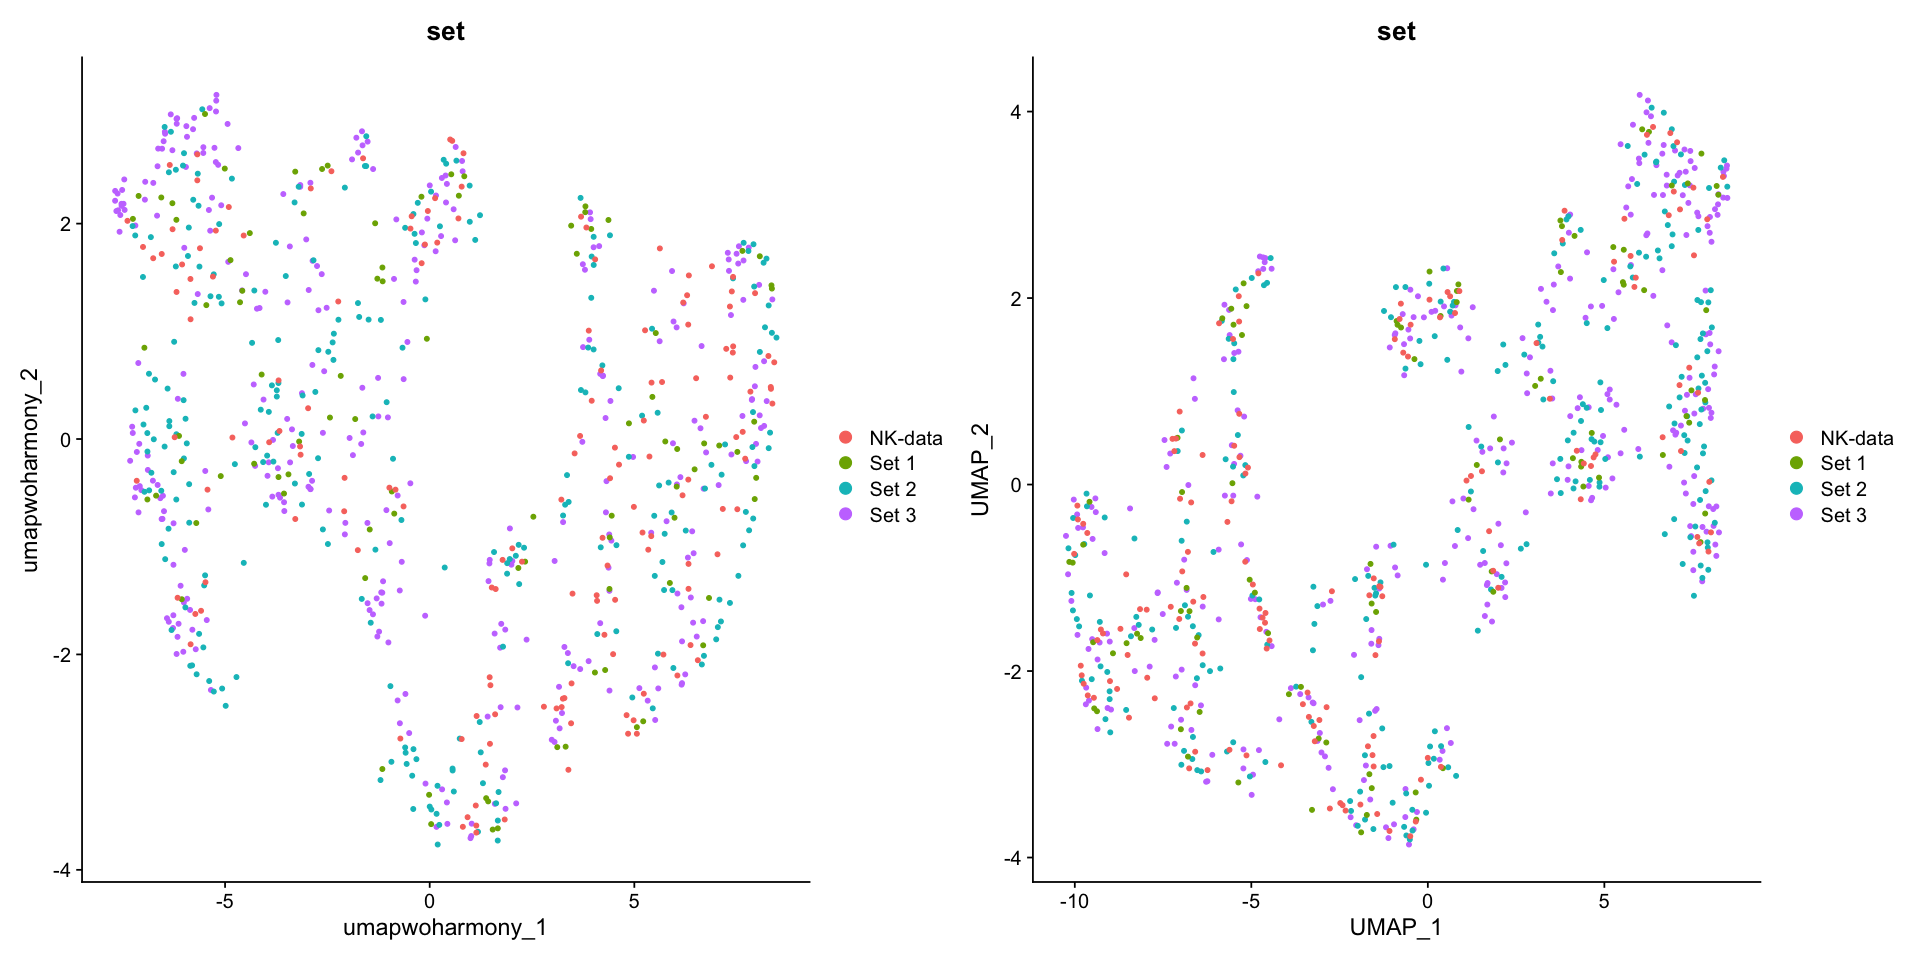

In [9]:
seu.head <-func.subclustering.prep(seu.head)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 819
Number of edges: 29084

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5006
Number of communities: 18
Elapsed time: 0 seconds


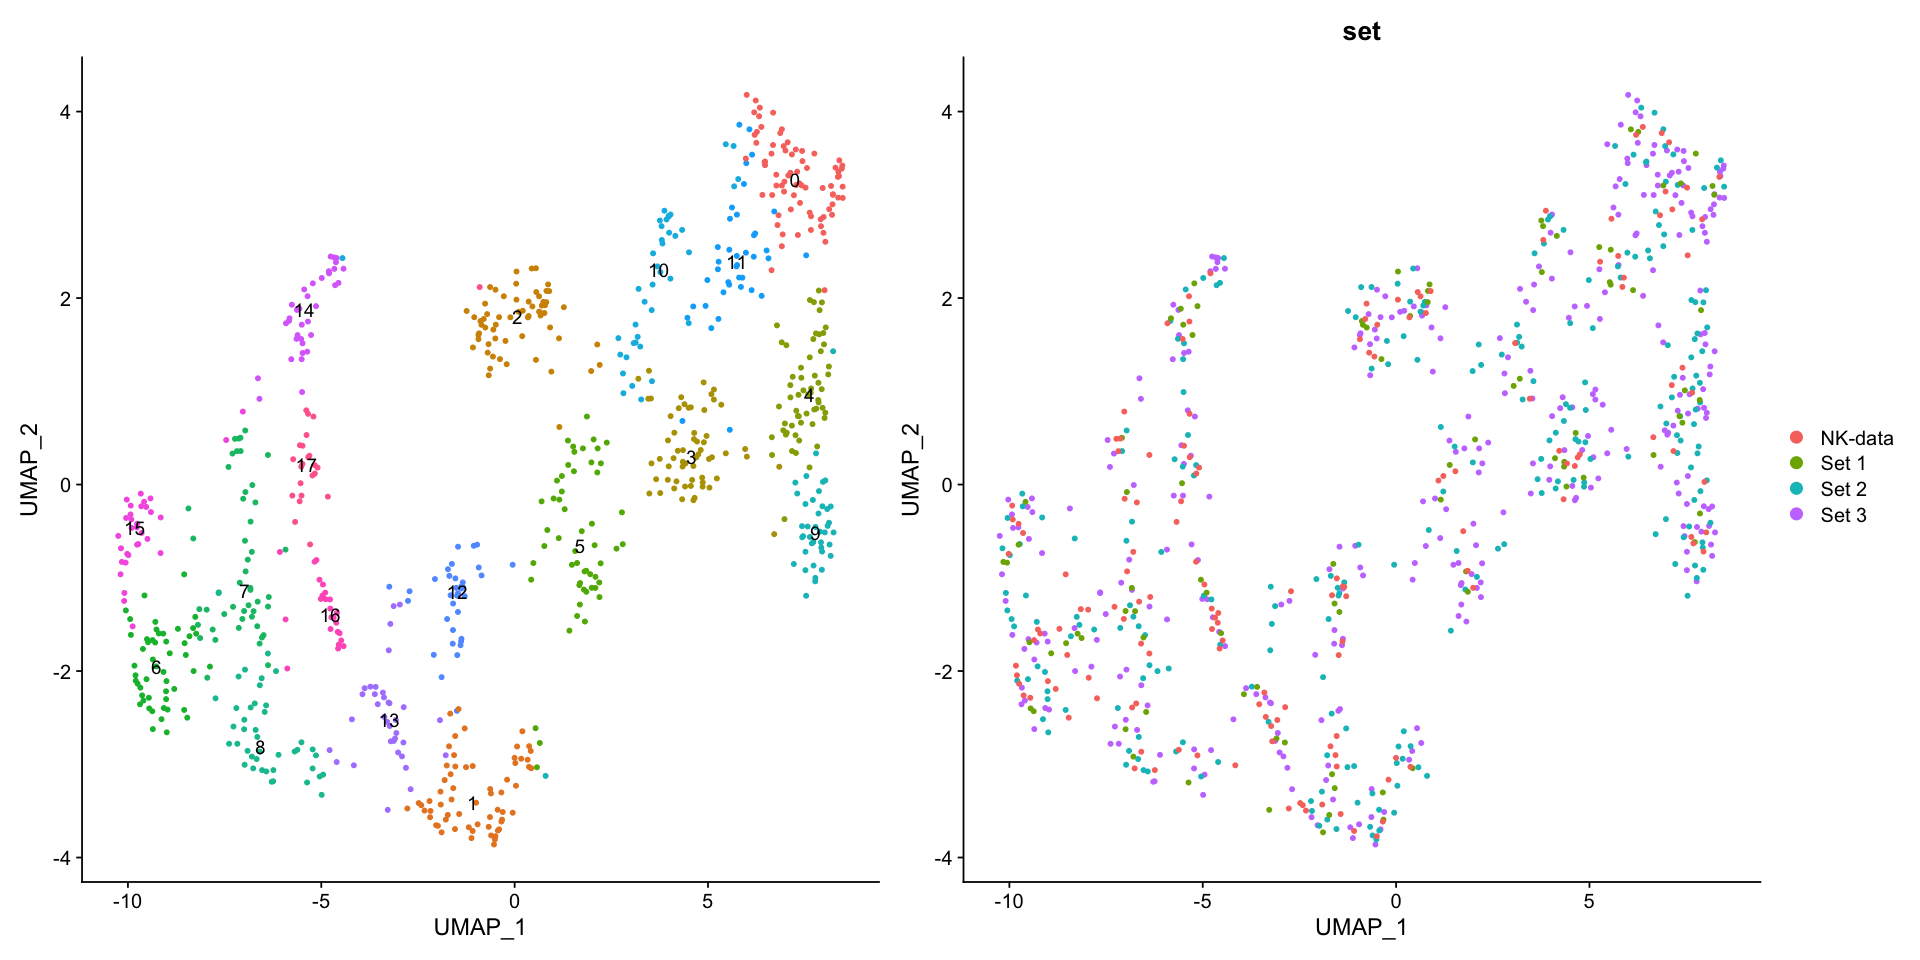

In [10]:
seu.head <-func.subclustering(seu.head, resolution = 4.0)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 819
Number of edges: 29084

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4693
Number of communities: 19
Elapsed time: 0 seconds


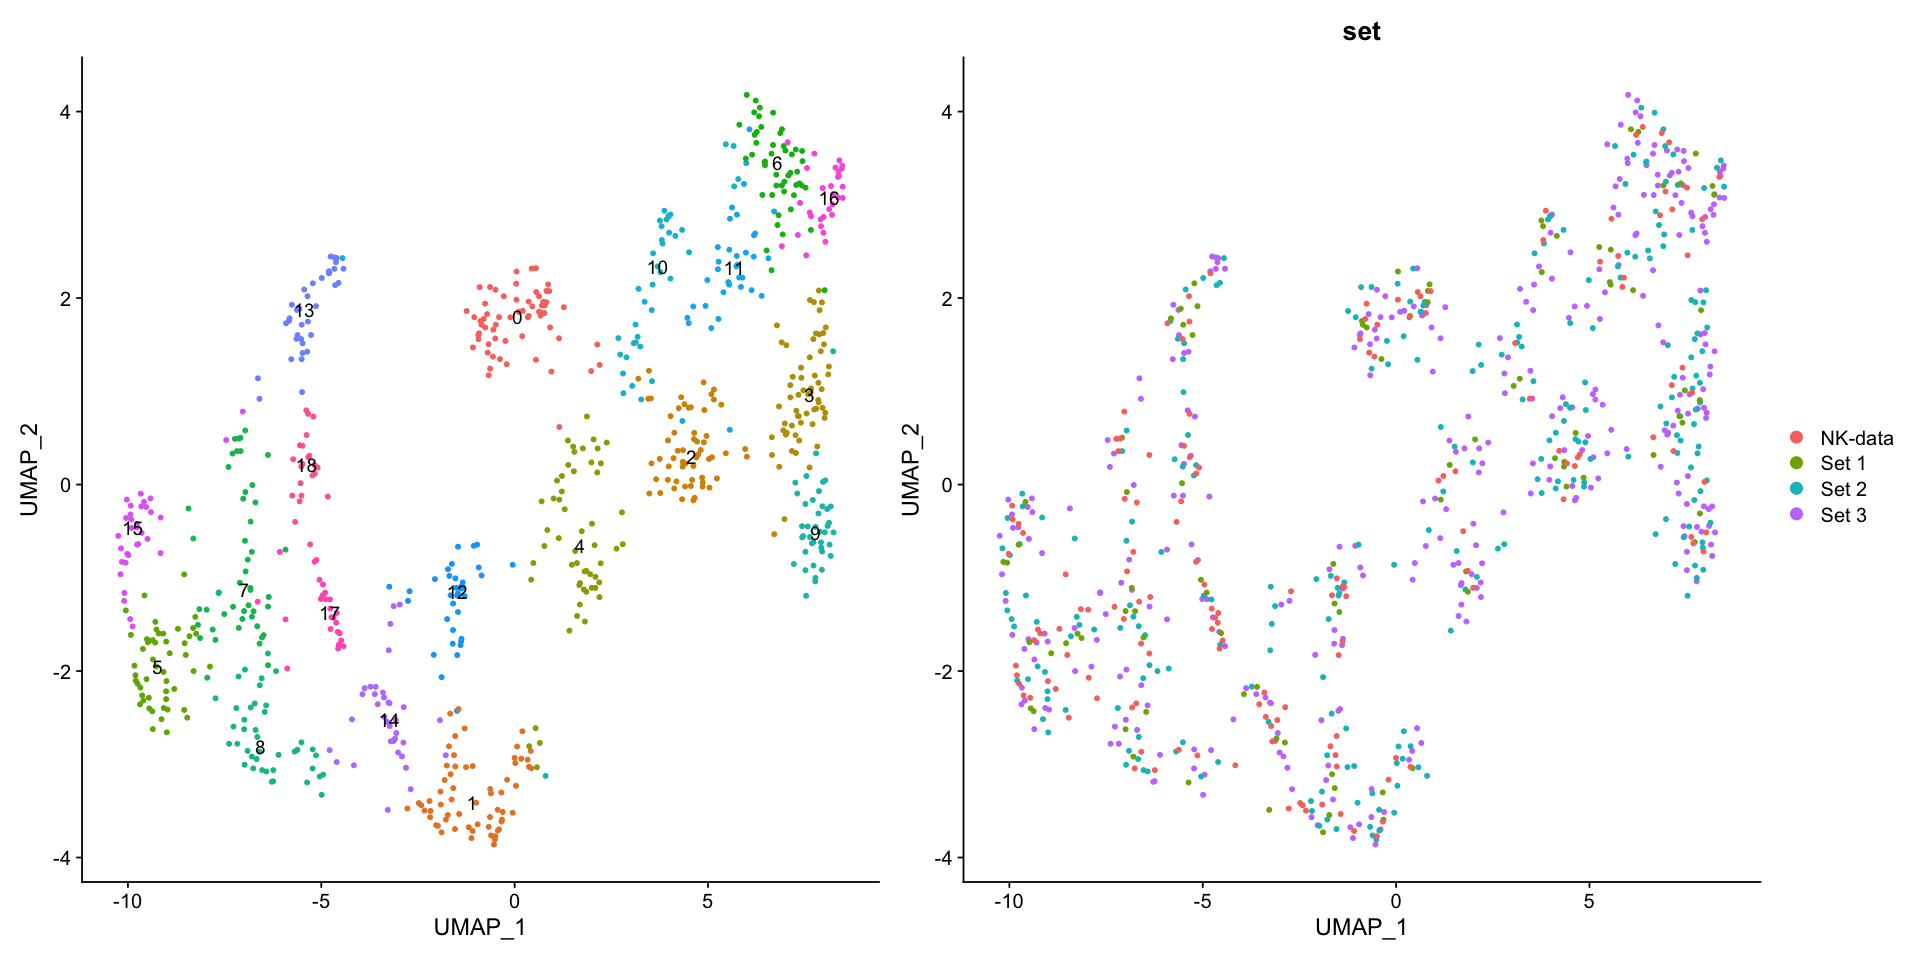

In [11]:
seu.head <-func.subclustering(seu.head, resolution = 4.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 819
Number of edges: 29084

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4516
Number of communities: 20
Elapsed time: 0 seconds


1 singletons identified. 19 final clusters.



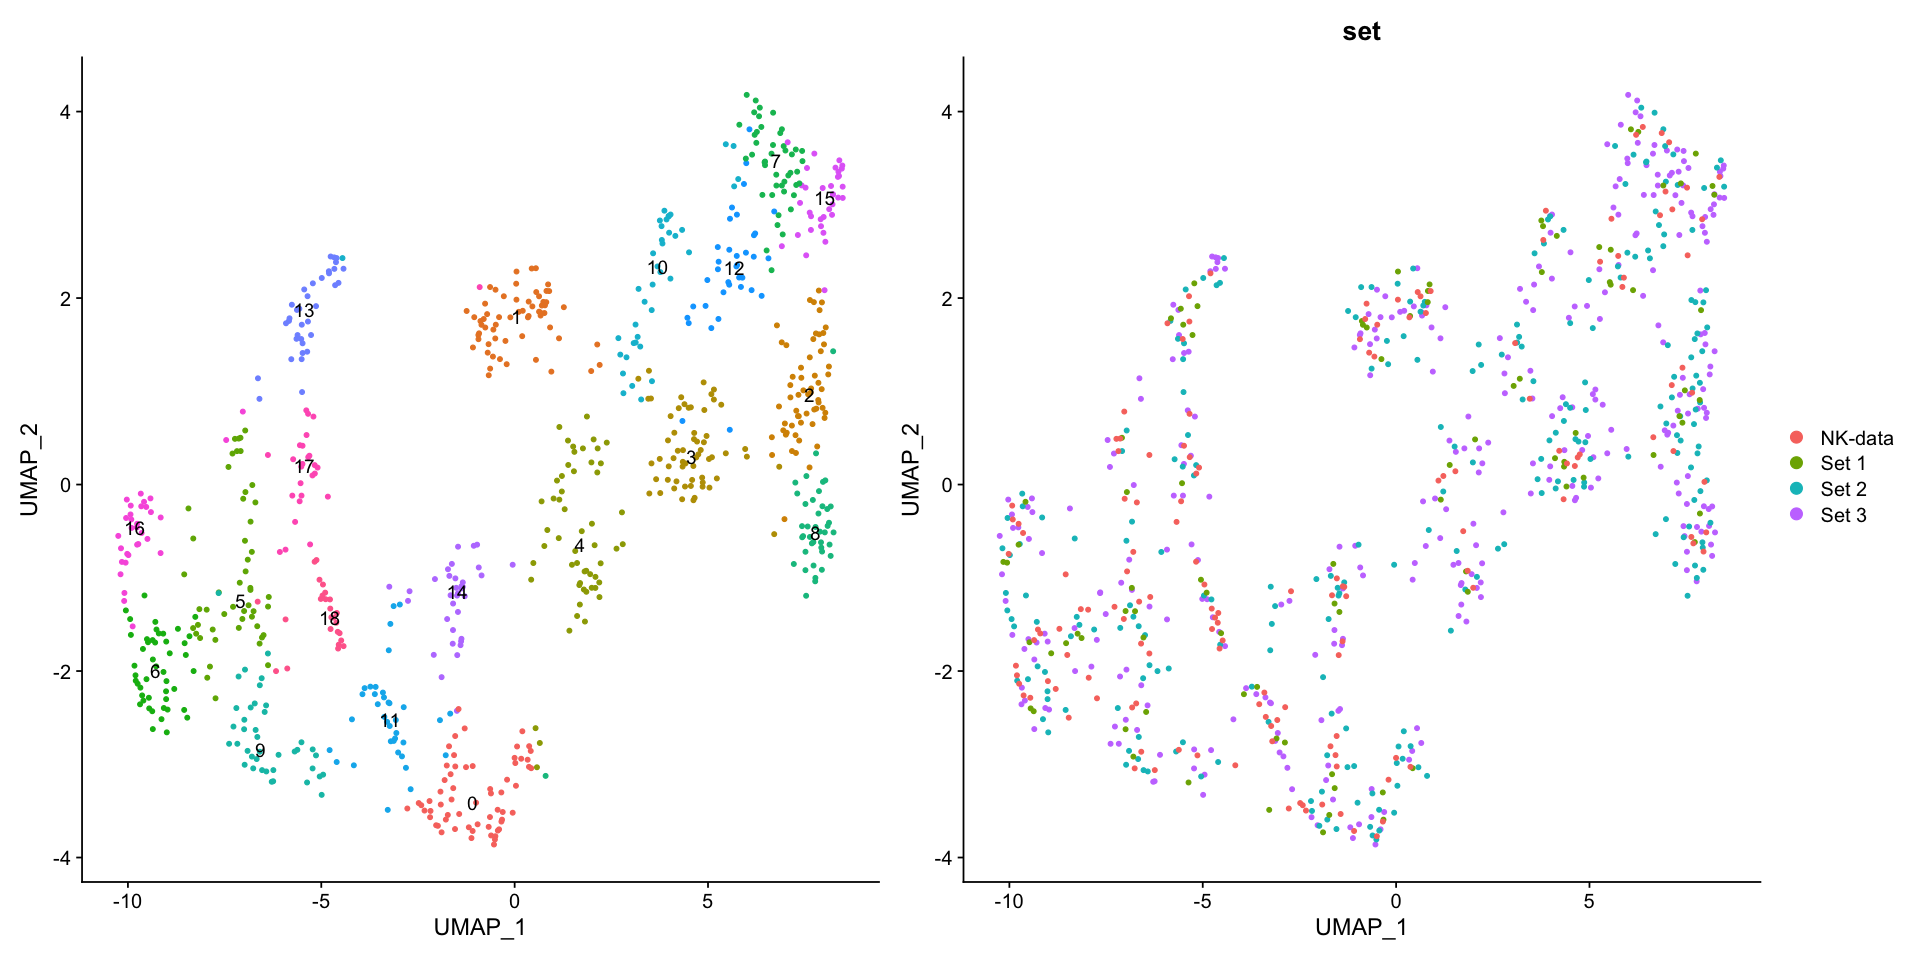

In [12]:
seu.head <-func.subclustering(seu.head, resolution = 4.8)

In [13]:
levels(seu.head) <- c(7,15,2,8,12,10,3,1,4,14,0,18,11,13,17,5,9,6,16)
all.markers <- FindAllMarkers(object = seu.head, only.pos = TRUE)
nrow(all.markers)
all.markers.top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
nrow(all.markers.top10)

Calculating cluster 7

Calculating cluster 15

Calculating cluster 2

Calculating cluster 8

Calculating cluster 12

Calculating cluster 10

Calculating cluster 3

Calculating cluster 1

Calculating cluster 4

Calculating cluster 14

Calculating cluster 0

Calculating cluster 18

Calculating cluster 11

Calculating cluster 13

Calculating cluster 17

Calculating cluster 5

Calculating cluster 9

Calculating cluster 6

Calculating cluster 16



[1] 1990

[1] 190

Warning message in DoHeatmap(seu.head, features = c("Dfd", "kn", "oc", "Optix", :
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: CG4456”


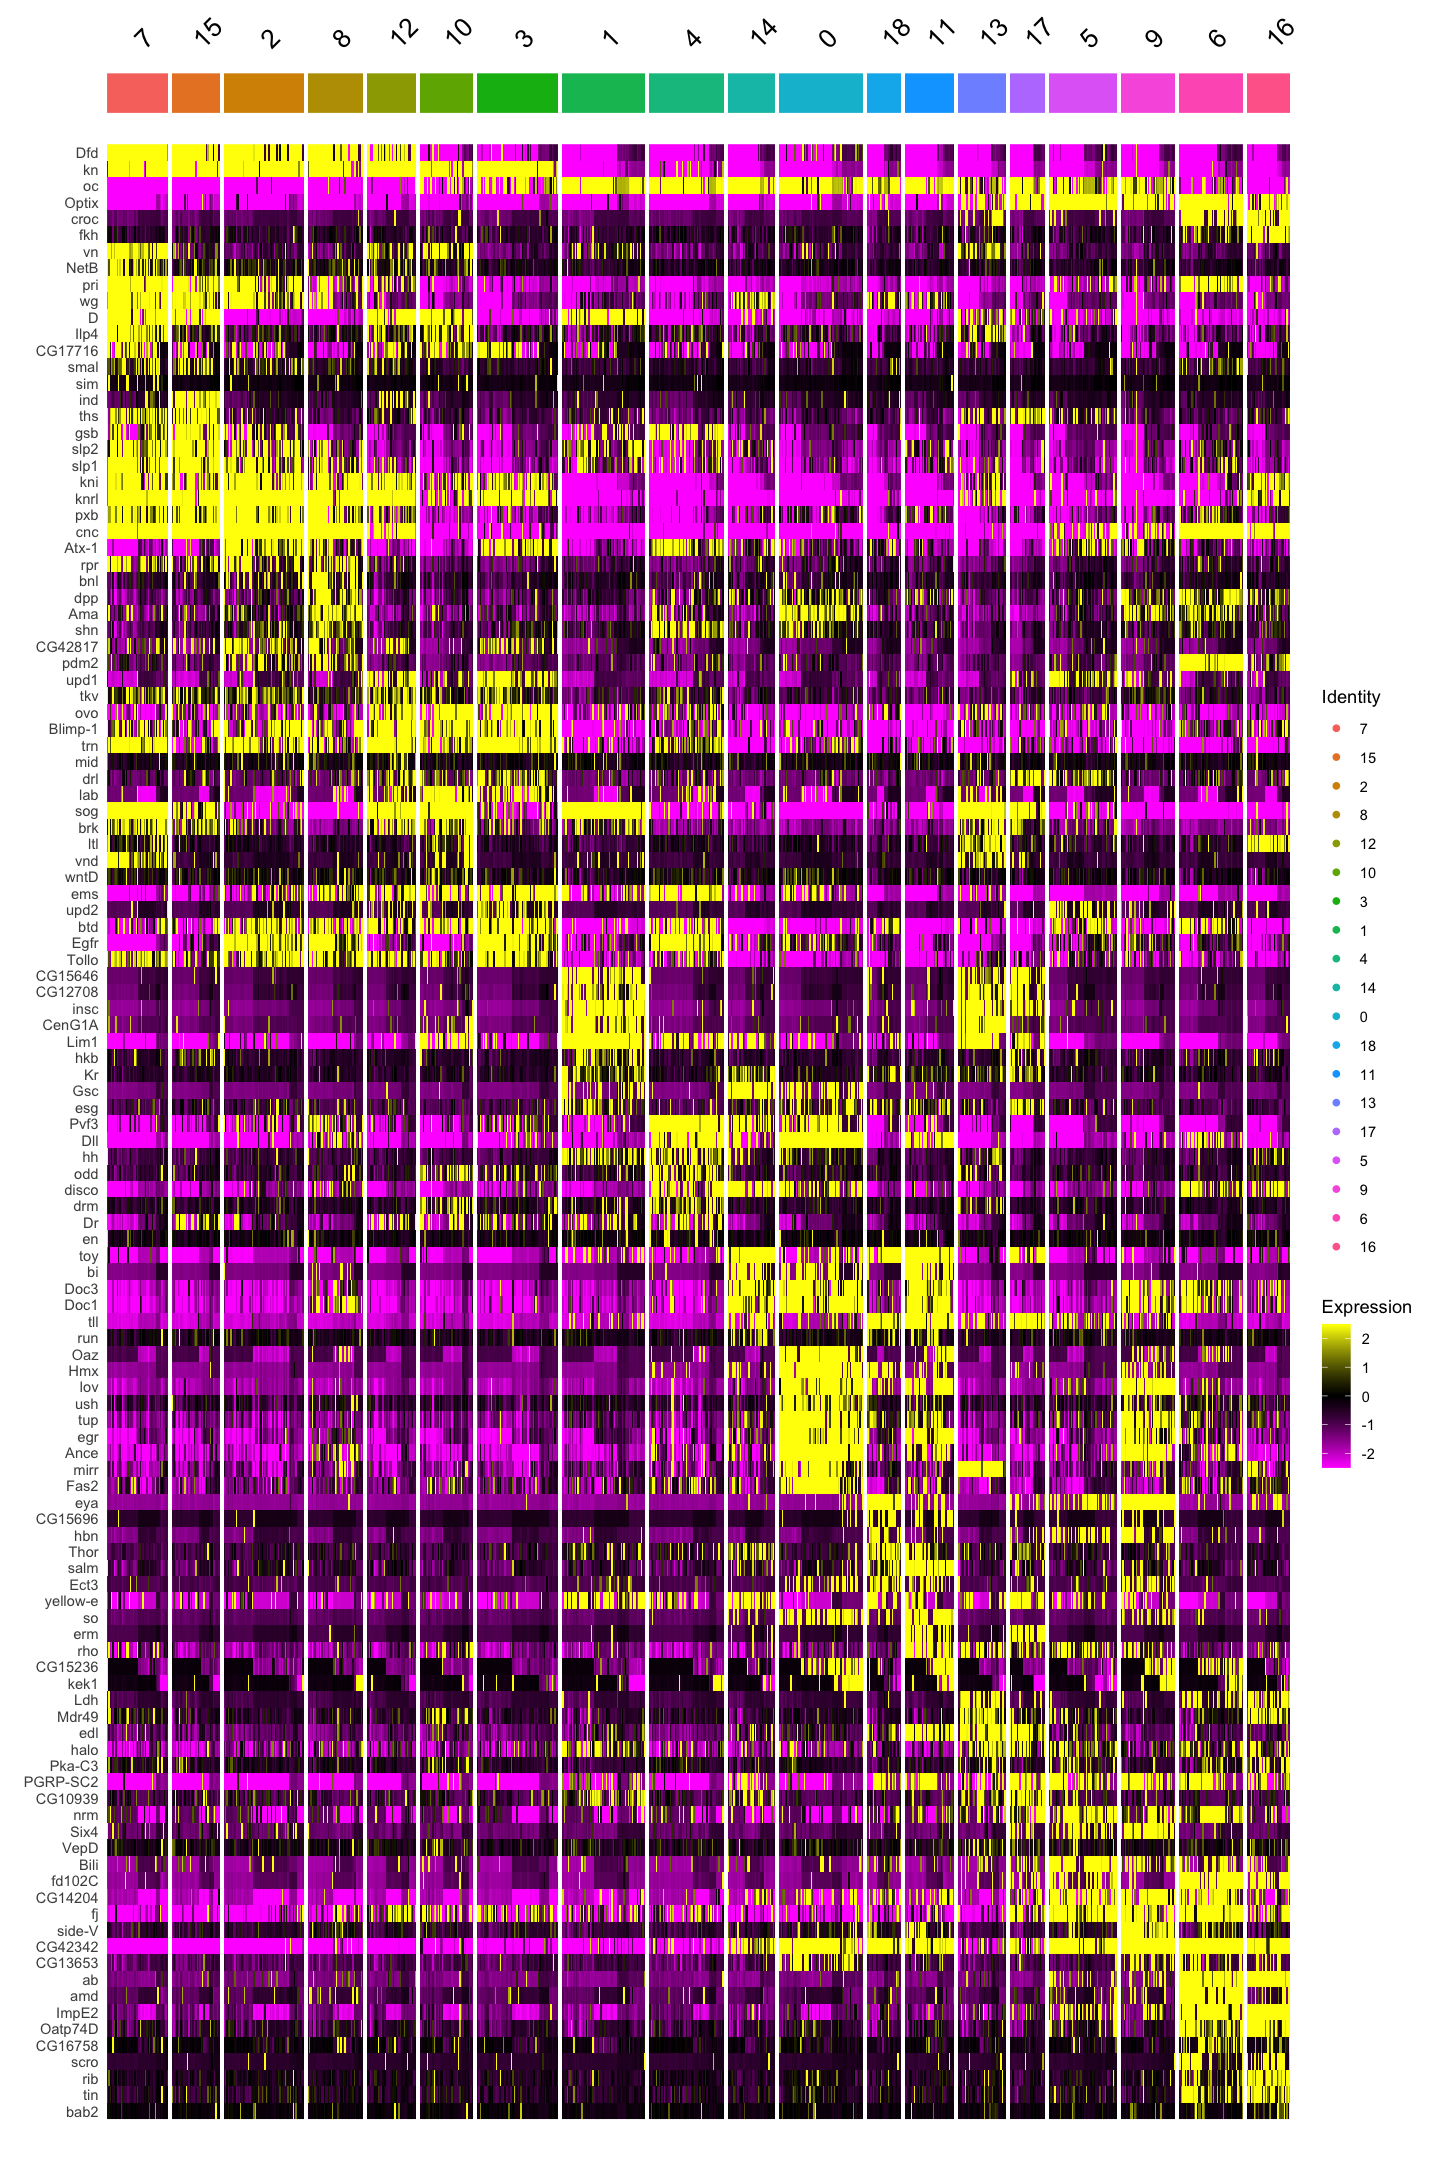

In [14]:
options(repr.plot.width=12, repr.plot.height=18)
DoHeatmap(seu.head, features = c('Dfd','kn','oc','Optix','croc','fkh',all.markers.top10$gene))

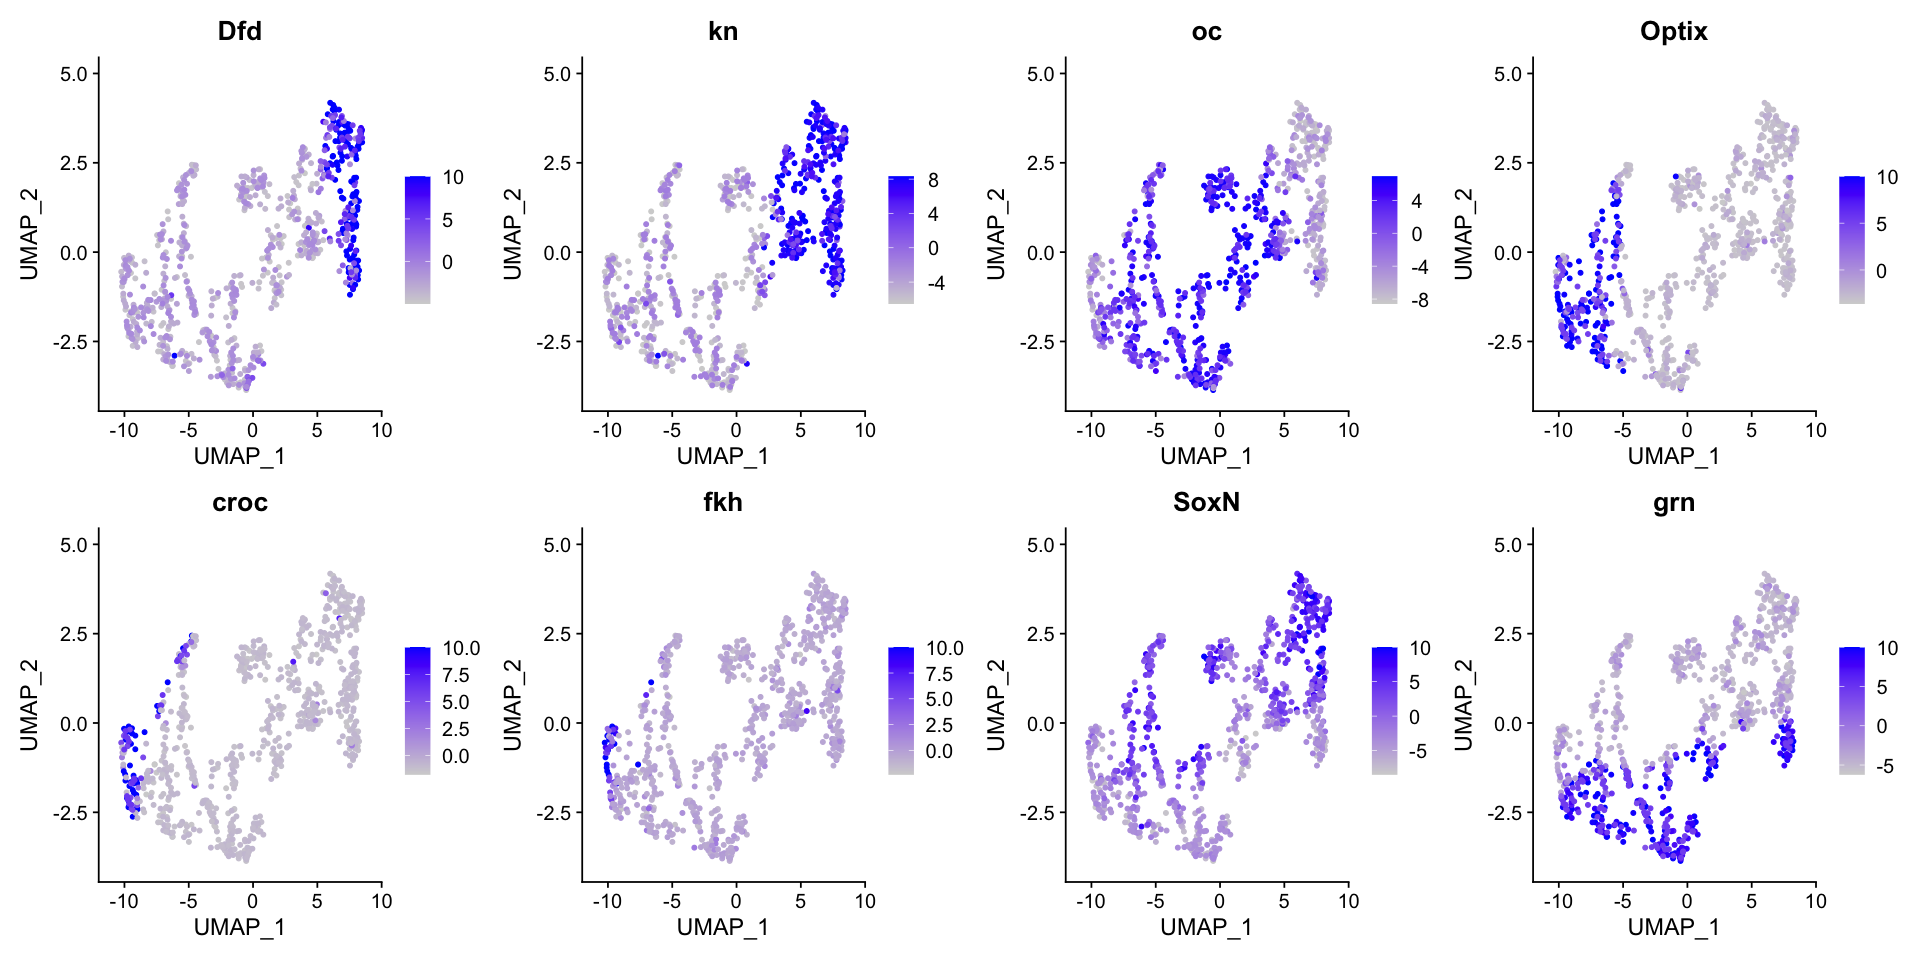

In [15]:
options(repr.plot.width=16, repr.plot.height=8)
FeaturePlot(seu.head, reduction = "umap", features = c('Dfd','kn','oc','Optix','croc','fkh','SoxN','grn'),
            pt.size = 1,  ncol = 4, slot ='scale.data')

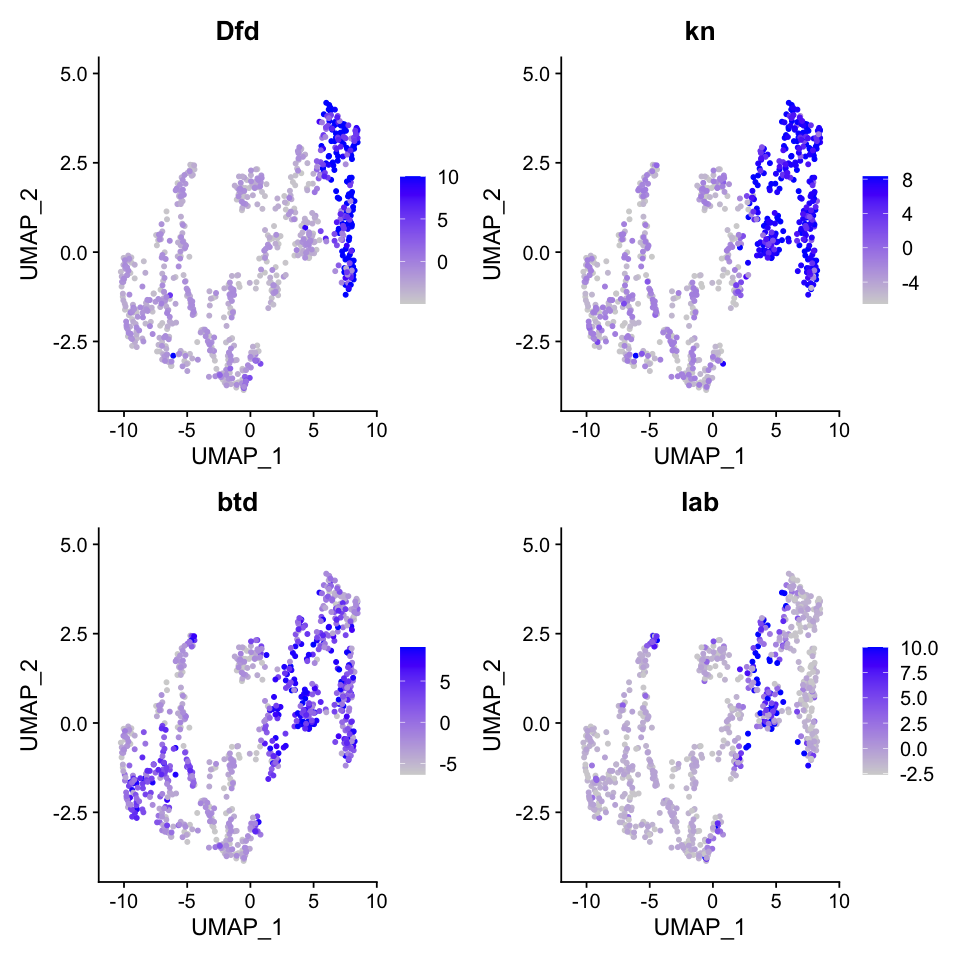

In [16]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu.head, reduction = "umap", features = c('Dfd','kn','btd','lab'), 
            pt.size = 1,  ncol = 2, slot = 'scale.data')

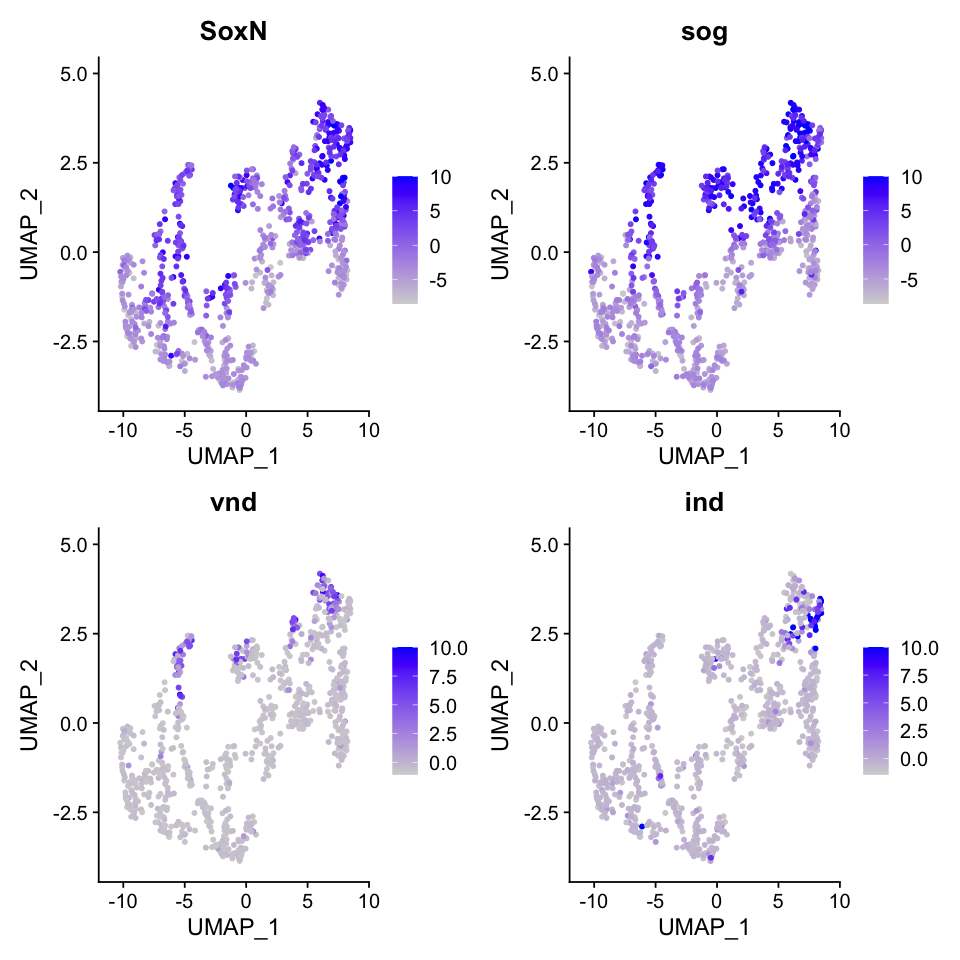

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu.head, reduction = "umap", features = c('SoxN','sog','vnd','ind'), 
            pt.size = 1,  ncol = 2, slot = 'scale.data')

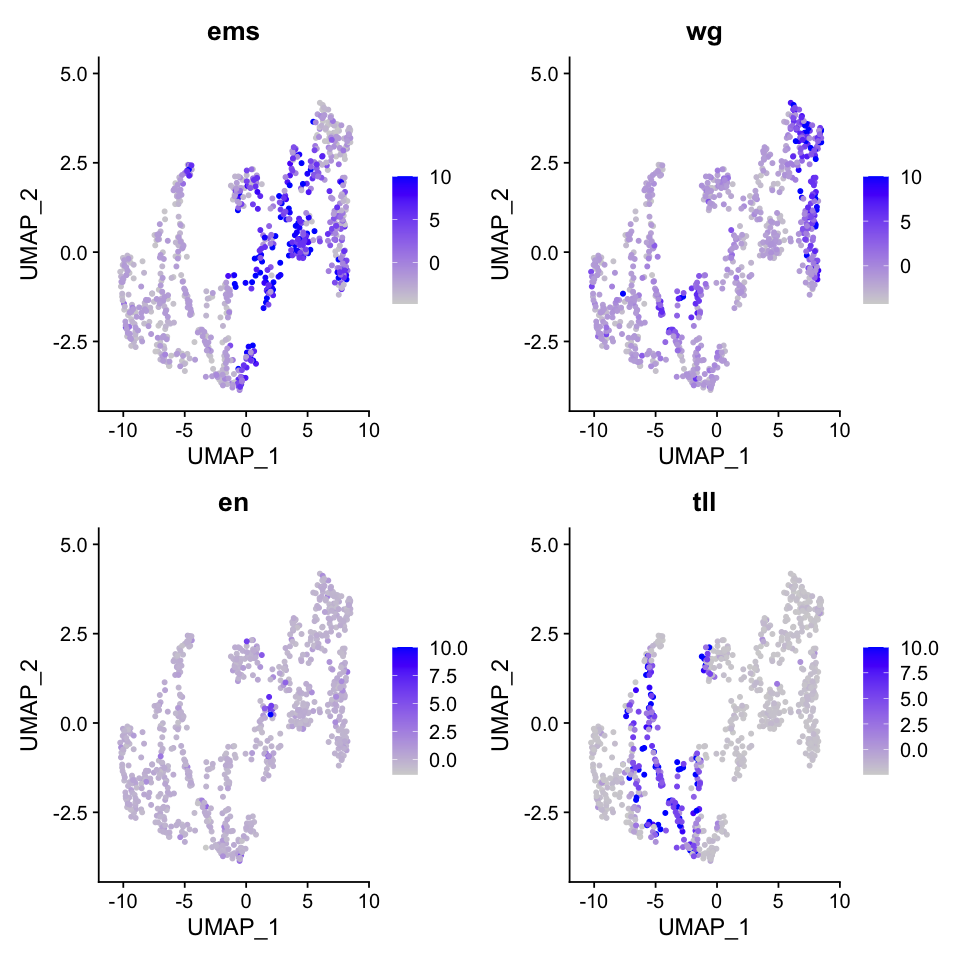

In [18]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu.head, reduction = "umap", features = c('ems','wg','en','tll'), 
            pt.size = 1,  ncol = 2, slot = 'scale.data')

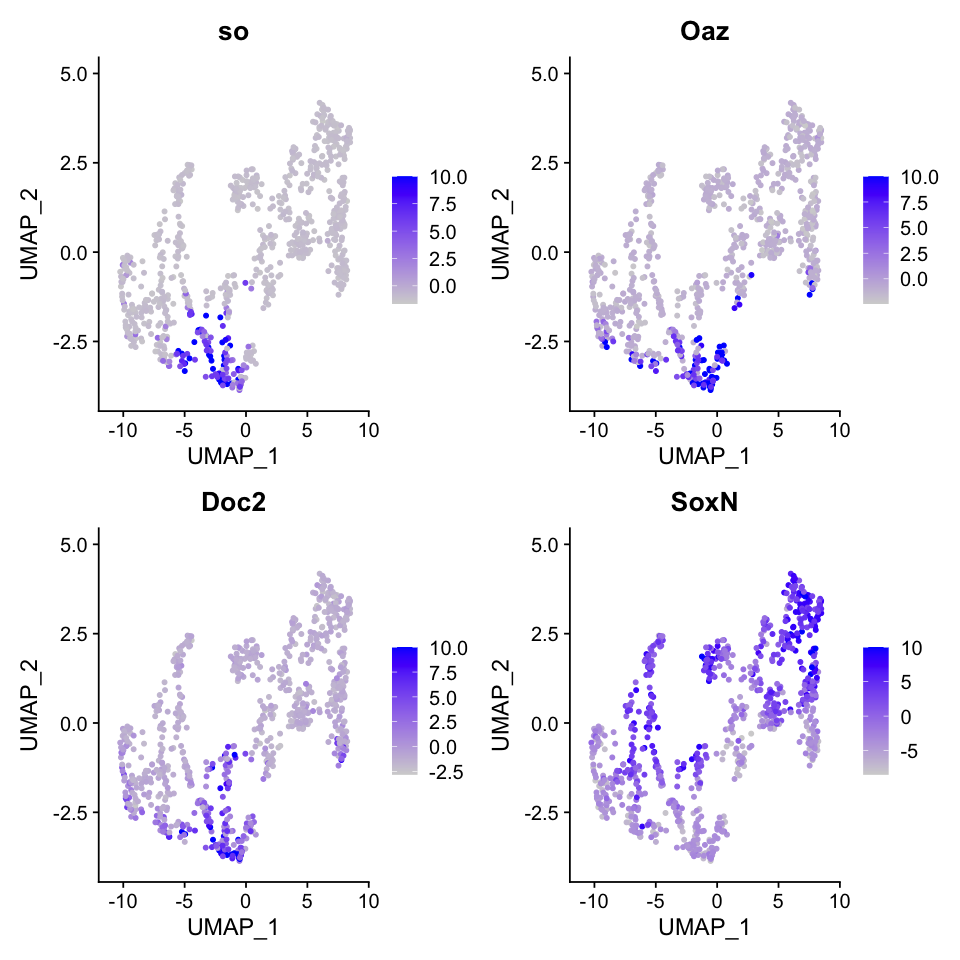

In [19]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu.head, reduction = "umap", features = c('so','Oaz','Doc2','SoxN'), 
            pt.size = 1,  ncol = 2, slot = 'scale.data')

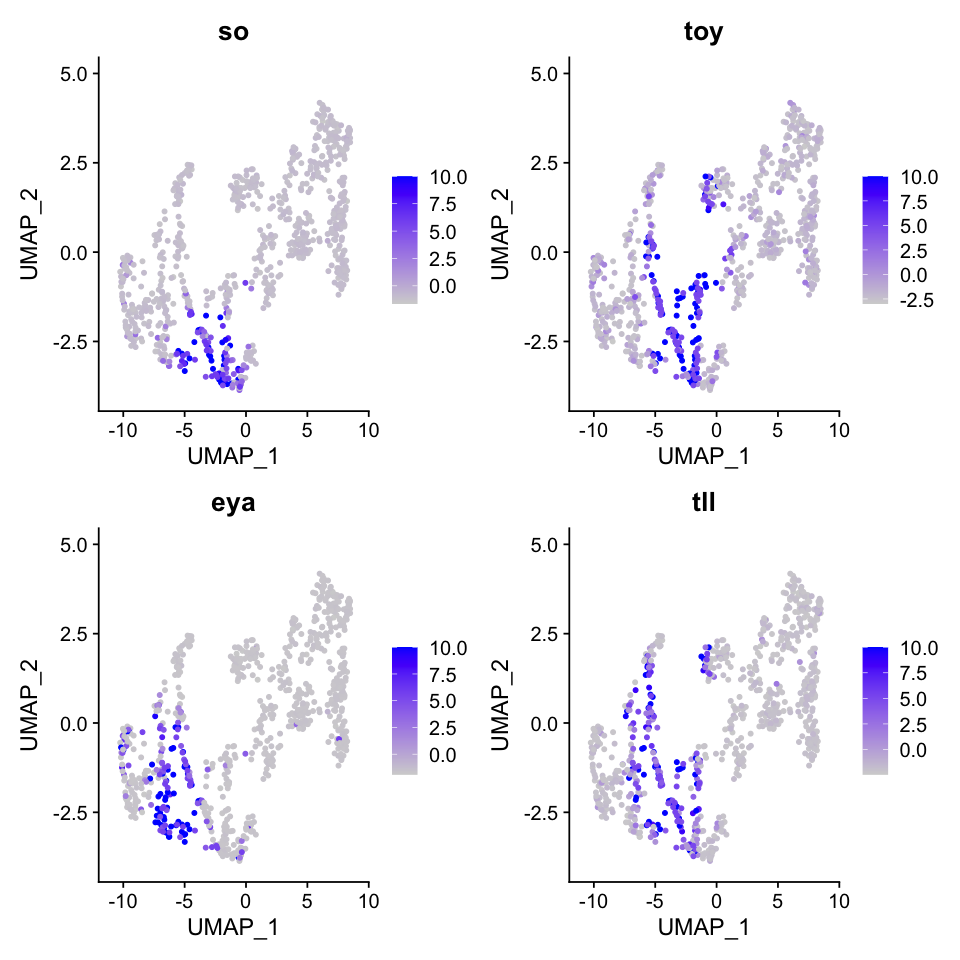

In [20]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu.head, reduction = "umap", features = c('so','toy','eya','tll'), 
            pt.size = 1,  ncol = 2, slot = 'scale.data')

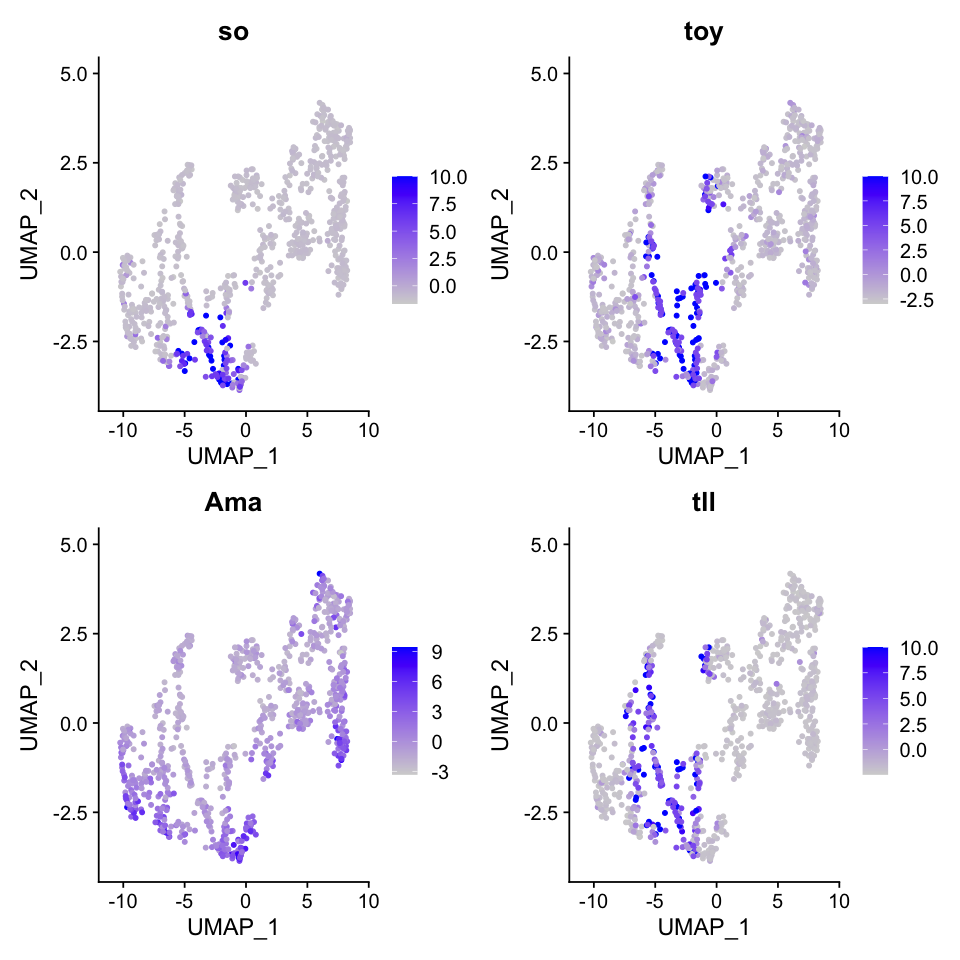

In [21]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(seu.head, reduction = "umap", features = c('so','toy','Ama','tll'), 
            pt.size = 1,  ncol = 2, slot = 'scale.data')

## Add annotation

manual_ID
Set3_GCGATCGTCGTTAGTG 8        
Set3_AAAGAACTCTCCTGCA 9        
Set3_AAAGTGAAGAGAAGGT 0        
Set3_AACAAAGAGATCACCT 14       
Set3_AACAAAGGTACGTGTT 15       
Set3_AACACACTCAGCGCAC 13

manual_ID                   
Set3_GCGATCGTCGTTAGTG ectoderm_DE_PS0             
Set3_AAAGAACTCTCCTGCA ectoderm_head_Optix_Six4_grn
Set3_AAAGTGAAGAGAAGGT ectoderm_head_oc_so         
Set3_AACAAAGAGATCACCT ectoderm_head_oc_Doc2       
Set3_AACAAAGGTACGTGTT ectoderm_intermediate_NE_PS0
Set3_AACACACTCAGCGCAC ectoderm_head_Optix_CenG1A

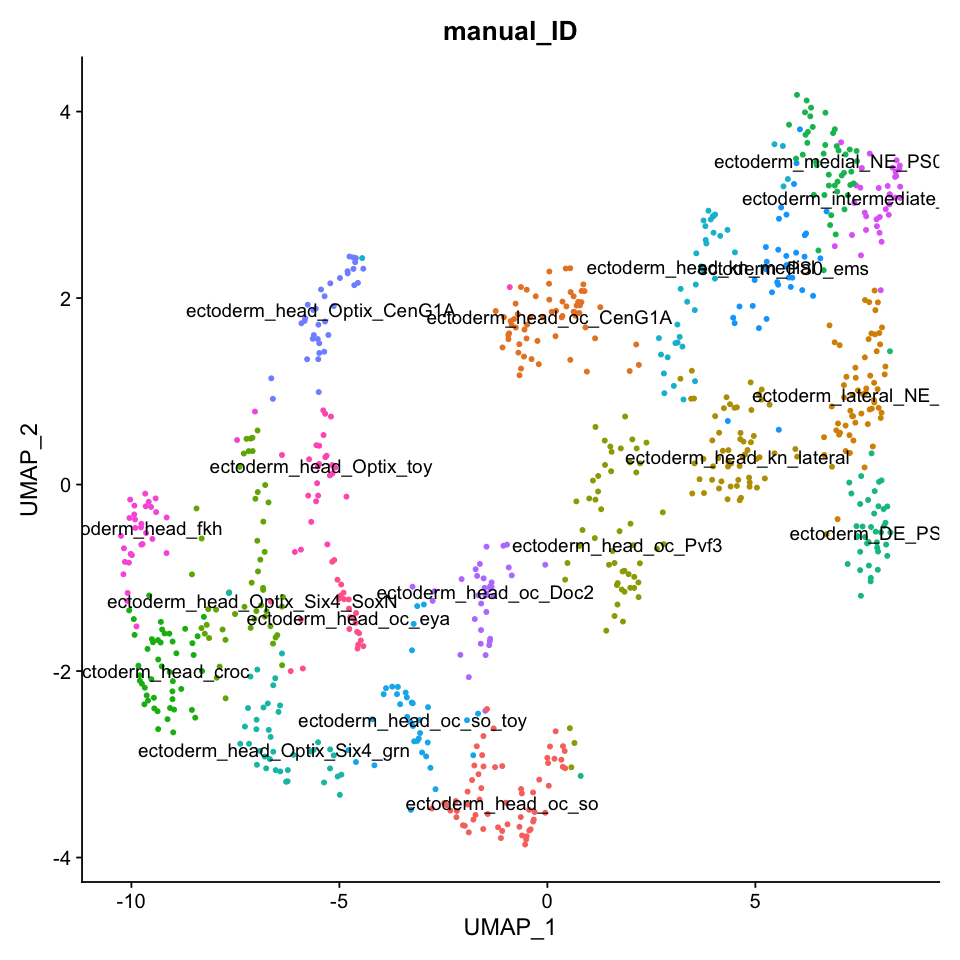

In [22]:
manual_id <- as.data.frame(seu.head$seurat_clusters)
colnames(manual_id) <- c('manual_ID')
head(manual_id)
manual_id$manual_ID = dplyr::recode(manual_id$manual_ID, 
                                     "0"="ectoderm_head_oc_so", #including head_oc_Oaz
                                     "1"="ectoderm_head_oc_CenG1A",
                                     "2"="ectoderm_lateral_NE_PS0",
                                     "3"="ectoderm_head_kn_lateral", #Atx-1+
                                     "4"="ectoderm_head_oc_Pvf3",
                                     "5"="ectoderm_head_Optix_Six4_SoxN",
                                     "6"="ectoderm_head_croc",
                                     "7"="ectoderm_medial_NE_PS0", #sog+
                                     "8"="ectoderm_DE_PS0",
                                     "9"="ectoderm_head_Optix_Six4_grn",
                                     "10"="ectoderm_head_kn_medial",
                                     "11"="ectoderm_head_oc_so_toy",
                                     "12"="ectoderm_PS0_ems",
                                     "13"="ectoderm_head_Optix_CenG1A",
                                     "14"="ectoderm_head_oc_Doc2",
                                     "15"="ectoderm_intermediate_NE_PS0",
                                     "16"="ectoderm_head_fkh",
                                     "17"="ectoderm_head_Optix_toy", #sog+
                                     "18"="ectoderm_head_oc_eya"
                                   )
                                    

head(manual_id)
seu.head$manual_ID <- manual_id
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu.head, reduction = 'umap', label = T, group.by = 'manual_ID') + NoLegend() 

In [23]:
Idents(seu.head) <- 'manual_ID'
levels <- c(7,15,2,8,12,10,3,1,4,14,0,18,11,13,17,5,9,6,16)
levels <- dplyr::recode(levels, 
                         "0"="ectoderm_head_oc_so", #including head_oc_Oaz
                         "1"="ectoderm_head_oc_CenG1A",
                         "2"="ectoderm_lateral_NE_PS0",
                         "3"="ectoderm_head_kn_lateral", #Atx-1+
                         "4"="ectoderm_head_oc_Pvf3",
                         "5"="ectoderm_head_Optix_Six4_SoxN",
                         "6"="ectoderm_head_croc",
                         "7"="ectoderm_medial_NE_PS0", #sog+
                         "8"="ectoderm_DE_PS0",
                         "9"="ectoderm_head_Optix_Six4_grn",
                         "10"="ectoderm_head_kn_medial",
                         "11"="ectoderm_head_oc_so_toy",
                         "12"="ectoderm_PS0_ems",
                         "13"="ectoderm_head_Optix_CenG1A",
                         "14"="ectoderm_head_oc_Doc2",
                         "15"="ectoderm_intermediate_NE_PS0",
                         "16"="ectoderm_head_fkh",
                         "17"="ectoderm_head_Optix_toy", #sog+
                         "18"="ectoderm_head_oc_eya" 
                       )
levels(seu.head) <- levels

In [24]:
all.markers <- FindAllMarkers(object = seu.head, only.pos = TRUE)
nrow(all.markers)
all.markers.top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
nrow(all.markers.top10)

Calculating cluster ectoderm_medial_NE_PS0

Calculating cluster ectoderm_intermediate_NE_PS0

Calculating cluster ectoderm_lateral_NE_PS0

Calculating cluster ectoderm_DE_PS0

Calculating cluster ectoderm_PS0_ems

Calculating cluster ectoderm_head_kn_medial

Calculating cluster ectoderm_head_kn_lateral

Calculating cluster ectoderm_head_oc_CenG1A

Calculating cluster ectoderm_head_oc_Pvf3

Calculating cluster ectoderm_head_oc_Doc2

Calculating cluster ectoderm_head_oc_so

Calculating cluster ectoderm_head_oc_eya

Calculating cluster ectoderm_head_oc_so_toy

Calculating cluster ectoderm_head_Optix_CenG1A

Calculating cluster ectoderm_head_Optix_toy

Calculating cluster ectoderm_head_Optix_Six4_SoxN

Calculating cluster ectoderm_head_Optix_Six4_grn

Calculating cluster ectoderm_head_croc

Calculating cluster ectoderm_head_fkh



[1] 1990

[1] 190

Saving 7 x 7 in image



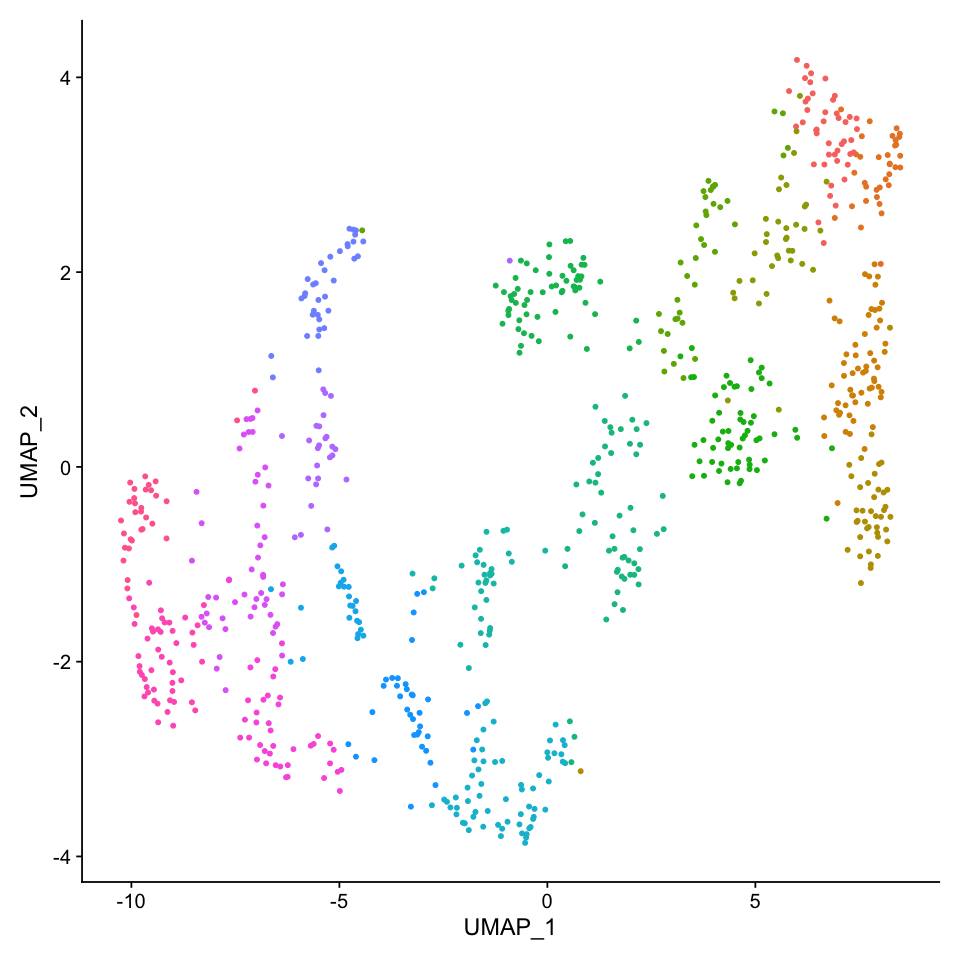

In [25]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu.head, reduction =  "umap", label = FALSE) + NoLegend() 

fig
ggsave(fig, file = "./figures/02_head_subclustering_integrate_all/head_umap1.eps", dpi = 300)

Saving 7 x 7 in image



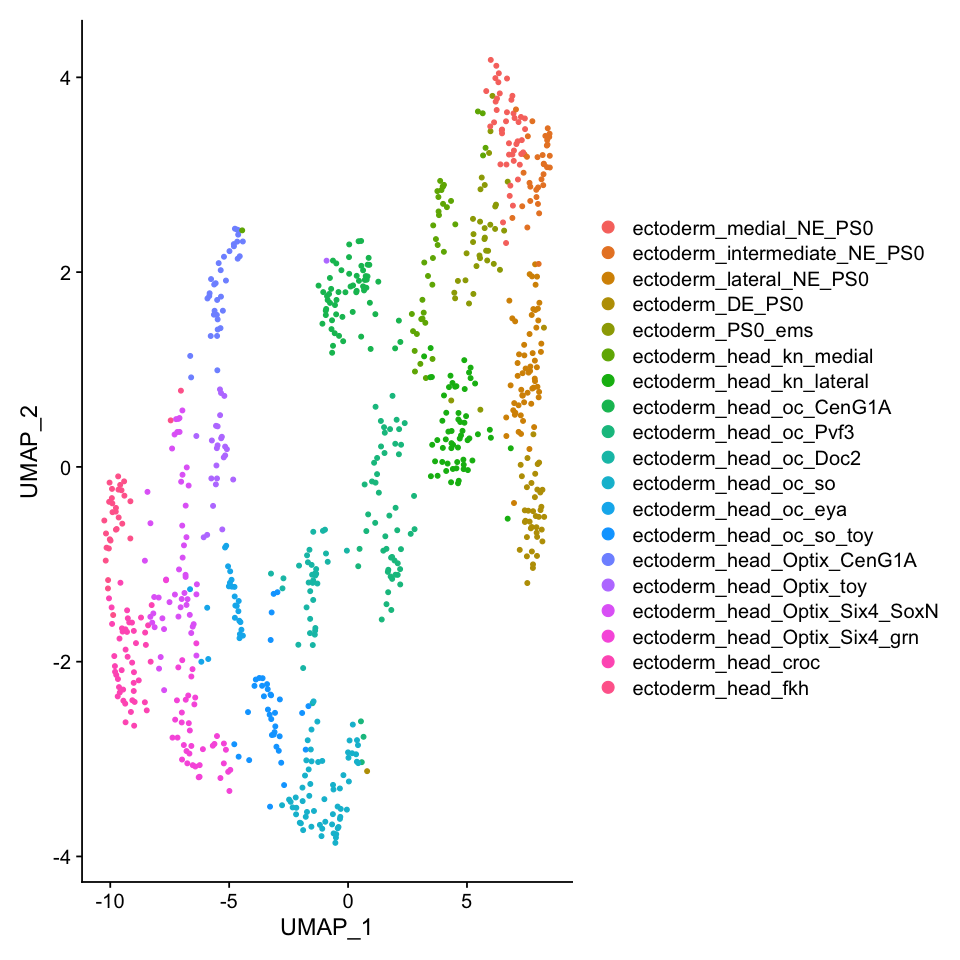

In [26]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu.head, reduction =  "umap", label = FALSE)

fig
ggsave(fig, file = "./figures/02_head_subclustering_integrate_all/head_umap2.eps", dpi = 300)

Warning message in DoHeatmap(seu.head, features = c(all.markers.top10$gene)):
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: CG4456”


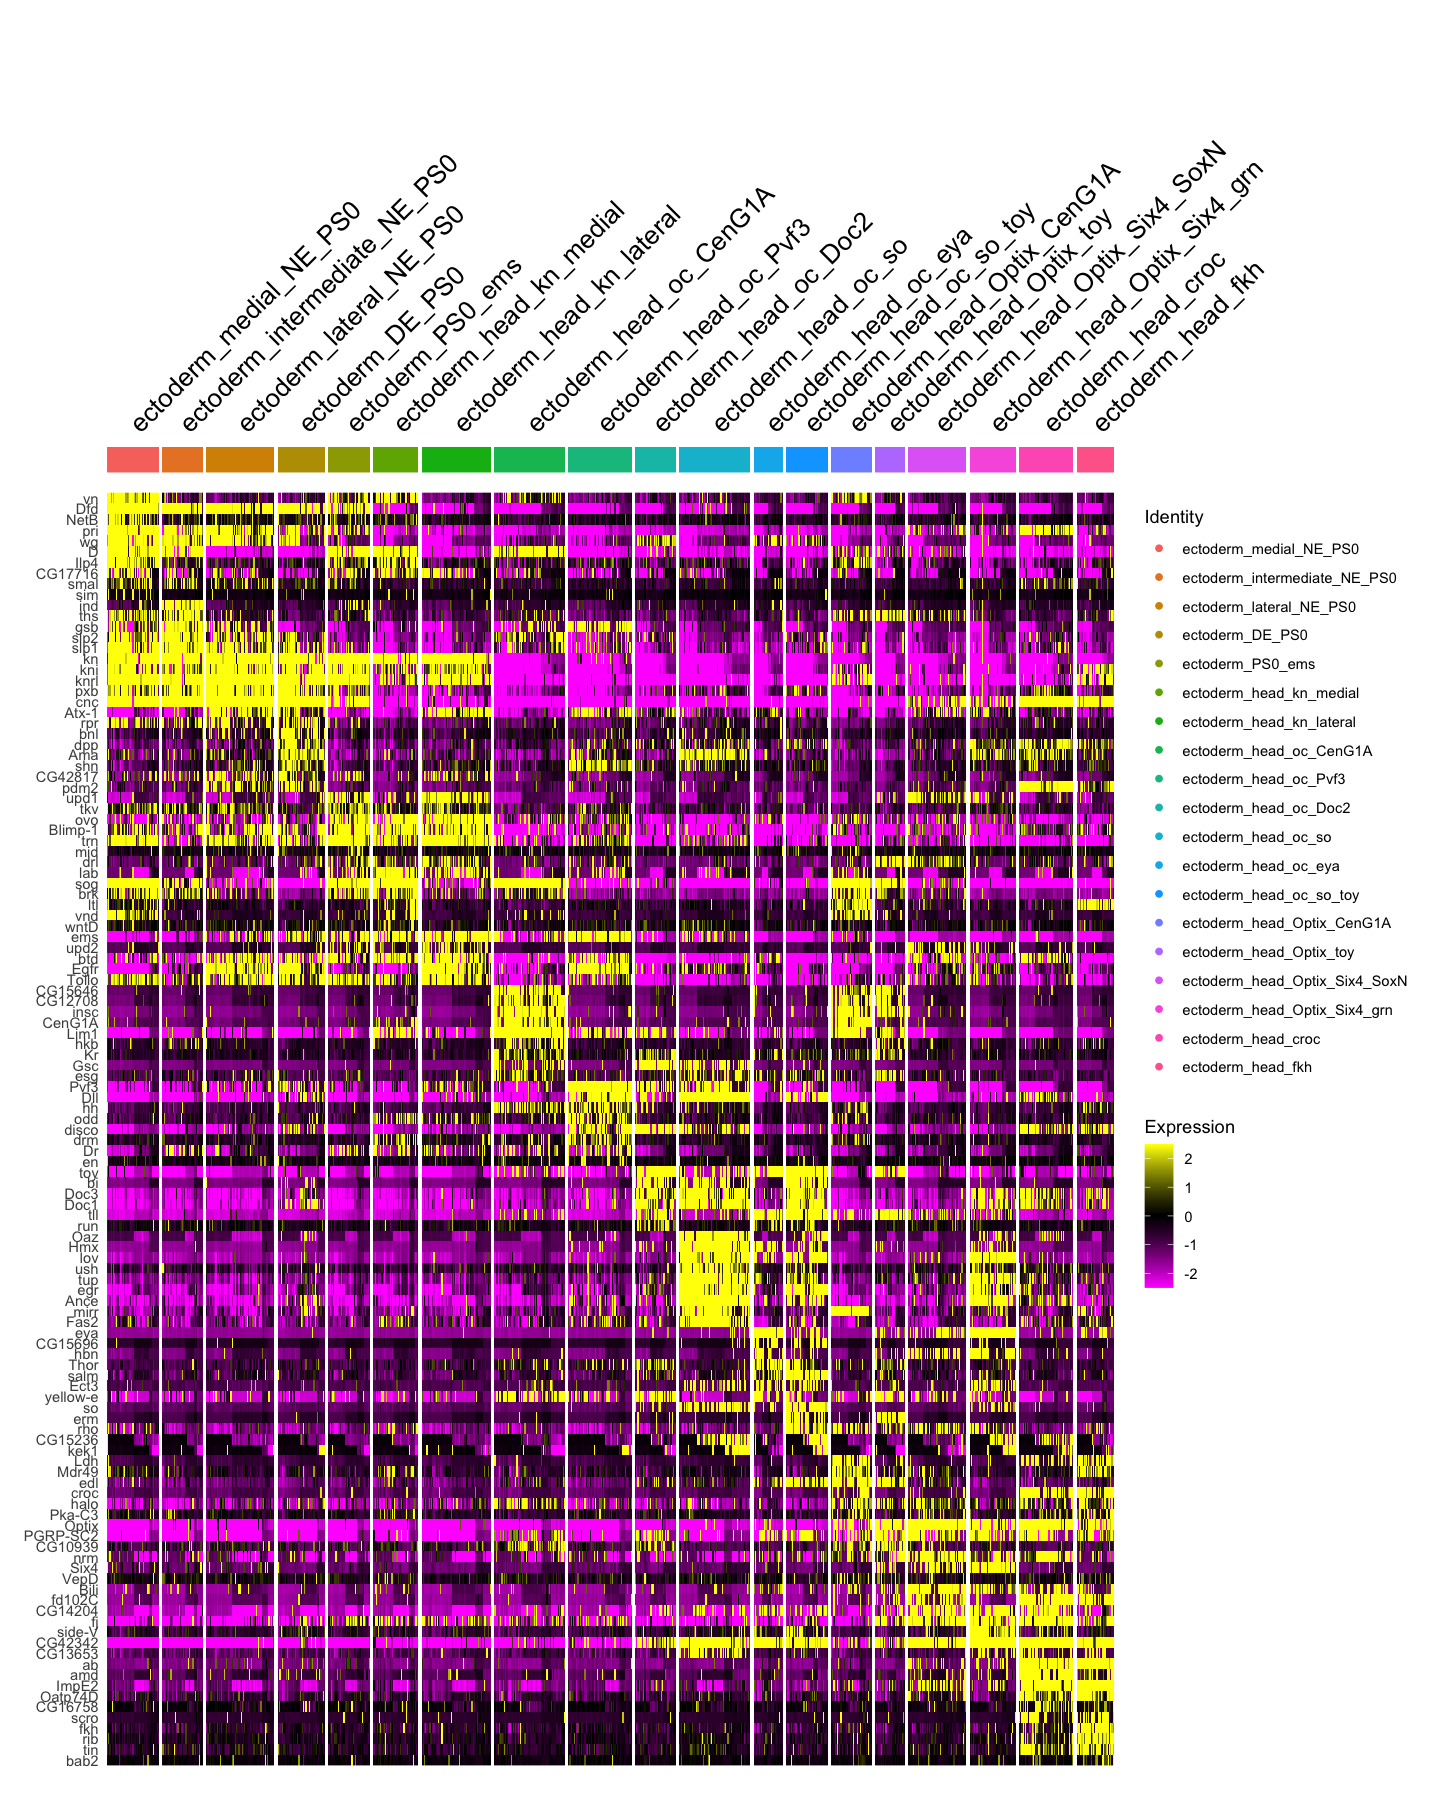

In [27]:
options(repr.plot.width=12, repr.plot.height=15)
fig <- DoHeatmap(seu.head, features = c(all.markers.top10$gene))
fig
ggsave(fig, file = "./figures/02_head_subclustering_integrate_all/head_manualID_heatmap.eps", dpi = 300,  width = 12, height = 8)

In [28]:
all.markers.top5 <- all.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)
nrow(all.markers.top5)

[1] 95

Warning message in DoHeatmap(seu.head, features = c(all.markers.top5$gene)):
“The following features were omitted as they were not found in the scale.data slot for the SCT assay: CG4456”


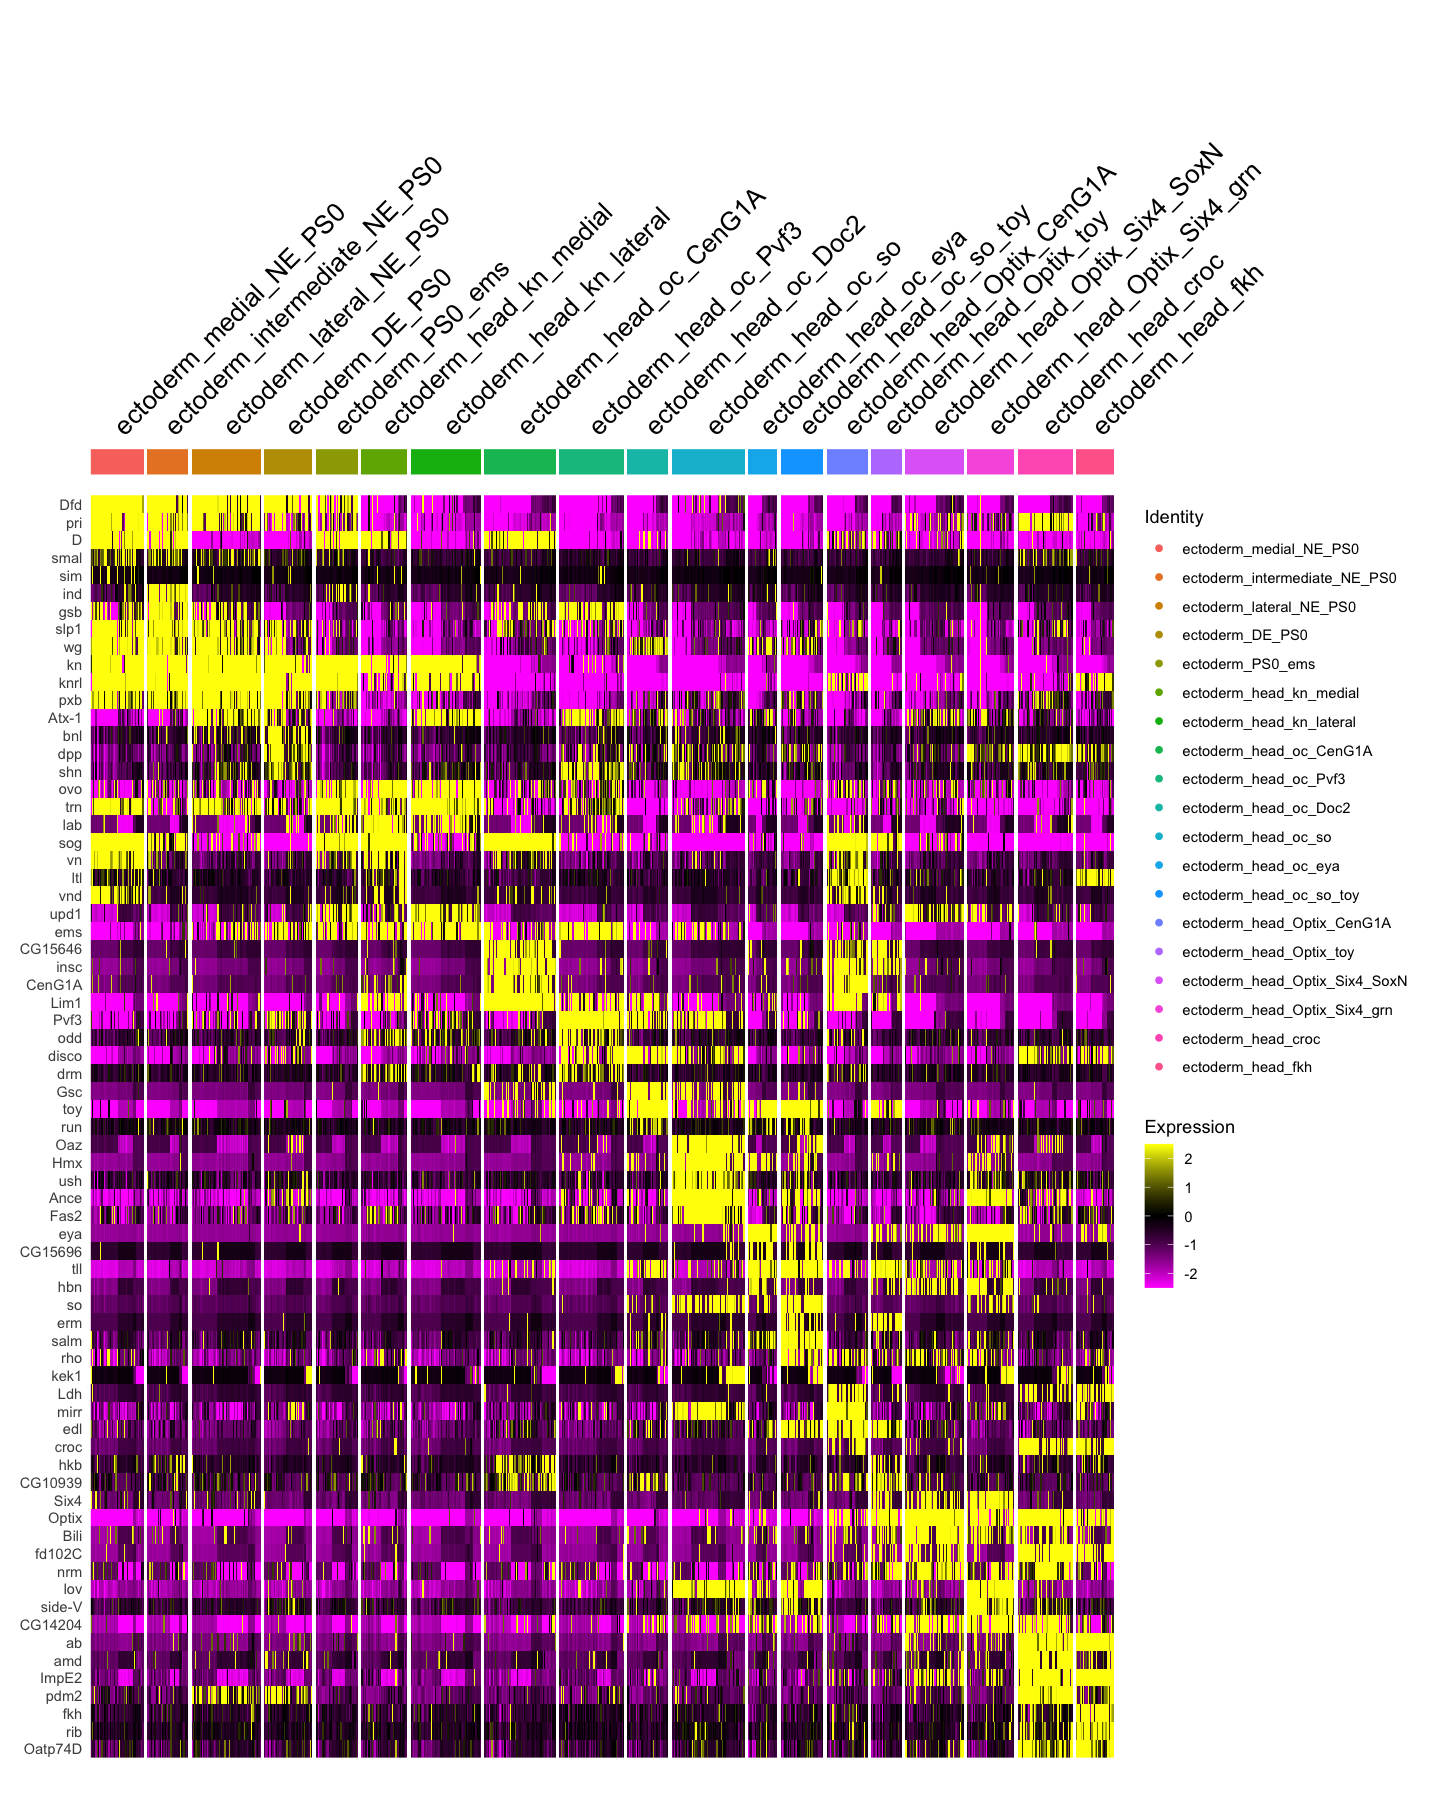

In [29]:
options(repr.plot.width=12, repr.plot.height=15)
fig <- DoHeatmap(seu.head, features = c(all.markers.top5$gene))
fig
ggsave(fig, file = "./figures/02_head_subclustering_integrate_all/head_manualID_heatmap_top5.eps", dpi = 300,  width = 12, height = 8)

In [30]:
saveRDS(object = seu.head, file = '../../data/seurat_object/all_integration/subclustering/seu_head_subclustering.obj')

In [31]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] harmony_0.1.0     Rcpp_1.0.7        tibble_3.0.5      dplyr_1.0.3      
[5] Matrix_1.3-2      data.table_1.13.6 magrittr_2.0.1    ggplot2_3.3.3    
[9] Seurat_3.2.3     

loaded via a namespace (and not attached):
  [1] nlme_3.1-151          matrixStats_0.57.0    RcppAnnoy_0.0.18     
  [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
  [7] sctransform_0.3.2     tools_4.0.3           R6_2.5.1             
 [10] irlba_2.3.3           rpart_4.1-15          KernSmooth_2.2